# Creates a 3d array containing the different PSF's from used in deconvolving the LOFAR image

The PSF image is read in and the PSF's cutout from the image. They are then stored in a 3d array along with a seperate 3d array that stores the coordinates of the PSF's.

In [1]:
from astropy.io import ascii, fits
import astropy
import pylab as plt
%matplotlib inline
from astropy import wcs
from astropy.table import Table,Column,join,hstack,vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
import pymoc
import glob
from time import sleep
import os
from astropy.nddata.utils import Cutout2D
from astropy.convolution import Gaussian2DKernel
#import herschelhelp.cutouts_server as ctts
import scipy

import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import xidplus.catalogue as cat

import sys
from herschelhelp_internal.utils import inMoc,flux_to_mag
from xidplus.stan_fit import SPIRE

import aplpy
import seaborn as sns
#sns.set(color_codes=True)
import pandas as pd
#sns.set_style("white")
import xidplus.posterior_maps as postmaps
#from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp import image_plotting,utils
import pyvo as vo
import glob

import copy

In [2]:
def get_cutout_data_and_wcs(image,ra,dec,wcs,box_length):
    
    c = SkyCoord(ra*u.degree,dec*u.degree,unit='deg')
    length_x, length_y = image_plotting.get_pix_length(image,wcs,box_length,ra,dec)
    pix_cent_x, pix_cent_y = wcs.wcs_world2pix(ra,dec,0,ra_dec_order=True)
    pixscale = np.array(wcs.wcs_pix2world(0,0,0)) - np.array(wcs.wcs_pix2world(1,1,0))
    if type(box_length)==list:
        imgcut = Cutout2D(image, c, size=[box_length[0]*u.degree,box_length[1]*u.degree], wcs=wcs)
    else:
        imgcut = Cutout2D(image, c, size=[box_length*u.degree,box_length*u.degree], wcs=wcs)
    wcscut = imgcut.wcs
    imgcut = imgcut.data
    
    return(imgcut,wcscut)

In [3]:
lofar_orig = Table.read('../data/data_release/final_cross_match_catalogue-v1.0.fits')
print(len(lofar_orig))
lofar_orig[0]

31610


<Row index=0 masked=True>
     Source_Name               RA                DEC                 E_RA                E_DEC               Total_flux           E_Total_flux            Peak_flux            E_Peak_flux      S_Code         Maj                   Min                  PA                 E_Maj                  E_Min                 E_PA         DC_Maj  DC_Min  DC_PA         Isl_rms         FLAG_WORKFLOW Prefilter  NoID       lr_fin             optRA              optDec      LGZ_Size LGZ_Width  LGZ_PA Assoc Assoc_Qual Art_prob Blend_prob Hostbroken_prob Imagemissing_prob Zoom_prob        Created         Position_from Renamed_from FLAG_OVERLAP_RADIO flag_clean_radio    ID    X_IMAGE  Y_IMAGE     ALPHA_J2000        DELTA_J2000    flag_clean ID_OPTICAL ID_SPITZER FLAG_OVERLAP     EBV        FUV_flux_corr       FUV_fluxerr_corr  FUV_mag_corr FUV_magerr_corr     NUV_flux_corr       NUV_fluxerr_corr  NUV_mag_corr NUV_magerr_corr     u_flux_corr        u_fluxerr_corr      u_mag_corr    u_magerr_corr    g_flux_corr       g_fluxerr_corr       g_mag_corr     g_magerr_corr r_flux_corr r_fluxerr_corr r_mag_corr r_magerr_corr i_flux_corr i_fluxerr_corr i_mag_corr i_magerr_corr    z_flux_corr        z_fluxerr_corr       z_mag_corr     z_magerr_corr y_flux_corr y_fluxerr_corr y_mag_corr y_magerr_corr g_hsc_flux_corr g_hsc_fluxerr_corr g_hsc_mag_corr g_hsc_magerr_corr r_hsc_flux_corr r_hsc_fluxerr_corr r_hsc_mag_corr r_hsc_magerr_corr i_hsc_flux_corr i_hsc_fluxerr_corr i_hsc_mag_corr i_hsc_magerr_corr z_hsc_flux_corr z_hsc_fluxerr_corr z_hsc_mag_corr z_hsc_magerr_corr y_hsc_flux_corr y_hsc_fluxerr_corr y_hsc_mag_corr y_hsc_magerr_corr nb921_hsc_flux_corr nb921_hsc_fluxerr_corr nb921_hsc_mag_corr nb921_hsc_magerr_corr    J_flux_corr      J_fluxerr_corr      J_mag_corr     J_magerr_corr    K_flux_corr       K_fluxerr_corr       K_mag_corr    K_magerr_corr ch1_swire_flux_corr ch1_swire_fluxerr_corr ch1_swire_mag_corr ch1_swire_magerr_corr ch2_swire_flux_corr ch2_swire_fluxerr_corr ch2_swire_mag_corr ch2_swire_magerr_corr ch3_swire_flux_corr ch3_swire_fluxerr_corr ch3_swire_mag_corr ch3_swire_magerr_corr ch4_swire_flux_corr ch4_swire_fluxerr_corr ch4_swire_mag_corr ch4_swire_magerr_corr ch1_servs_flux_corr ch1_servs_fluxerr_corr ch1_servs_mag_corr ch1_servs_magerr_corr ch2_servs_flux_corr ch2_servs_fluxerr_corr ch2_servs_mag_corr ch2_servs_magerr_corr Separation           help_id                RA_HELP           DEC_HELP      CLASS_STAR F_MIPS_24 FErr_MIPS_24_u FErr_MIPS_24_l  Bkg_MIPS_24  Sig_conf_MIPS_24 Rhat_MIPS_24 n_eff_MIPS_24 Pval_res_24 flag_mips_24 F_PACS_100 FErr_PACS_100_u FErr_PACS_100_l F_PACS_160 FErr_PACS_160_u FErr_PACS_160_l  Bkg_PACS_100  Bkg_PACS_160 Sig_conf_PACS_100 Sig_conf_PACS_160 Rhat_PACS_100 Rhat_PACS_160 n_eff_PACS_100 n_eff_PACS_160 Pval_res_100 Pval_res_160 flag_PACS_100 flag_PACS_160 F_SPIRE_250 FErr_SPIRE_250_u FErr_SPIRE_250_l F_SPIRE_350 FErr_SPIRE_350_u FErr_SPIRE_350_l F_SPIRE_500 FErr_SPIRE_500_u FErr_SPIRE_500_l Bkg_SPIRE_250 Bkg_SPIRE_350 Bkg_SPIRE_500 Sig_conf_SPIRE_250 Sig_conf_SPIRE_350 Sig_conf_SPIRE_500 Rhat_SPIRE_250 Rhat_SPIRE_350 Rhat_SPIRE_500 n_eff_SPIRE_250 n_eff_SPIRE_500 n_eff_SPIRE_350 Pval_res_250 Pval_res_350 Pval_res_500 flag_spire_250 flag_spire_350 flag_spire_500  Z_BEST Z_BEST_SOURCE  Z_SPEC Z_SOURCE  Z_QUAL z1_median  z1_min  z1_max z1_area z2_median  z2_min  z2_max z2_area nfilt_eazy nfilt_atlas nfilt_ananna chi_r_best chi_r_stellar stellar_type  AGN   optAGN  IRAGN  XrayAGN 2RXS_ID XMMSL2_ID ap_to_model_g ap_to_model_err_g ap_to_model_r ap_to_model_err_r   ap_to_model_z    ap_to_model_err_z  zmodel chi_best Mass_median Mass_l68 Mass_u68 Nfilts  u_rest  g_rest  r_rest  i_rest  z_rest  y_rest  J_rest  K_rest ch1_servs_rest ch2_servs_rest ch1_swire_rest ch2_swire_rest ch3_swire_rest ch4_swire_rest XID+_rerun_mips XID+_rerun_pacs XID+_rerun_SPIRE
       bytes22              float64            float64             float64              float64               float64               float64 

In [4]:
lofar_component = Table.read('../data/data_release/final_component_catalogue-v1.0.fits')
print(len(lofar_component))
lofar_component[0]

86000


<Row index=0>
    Component_Name             RA                DEC                E_RA                 E_DEC              Total_flux         E_Total_flux          Peak_flux            E_Peak_flux      S_Code         Maj                  Min                  PA                E_Maj                 E_Min                E_PA               DC_Maj               DC_Min              DC_PA             Created      Deblended_from     Parent_Source     
       bytes22              float64            float64            float64               float64              float64             float64              float64               float64        bytes1       float64              float64             float64             float64               float64             float64             float64              float64             float64            bytes29         bytes22            bytes22        
---------------------- ------------------ ----------------- -------------------- --------------------- ------------------- -------------------- -------------------- --------------------- ------ -------------------- -------------------- ------------------ -------------------- --------------------- ------------------ -------------------- -------------------- ------------------ ----------------- -------------- ----------------------
ILTJ153936.98+580651.7 234.90409574742577 58.11436685178417 0.000910655435717371 0.0010915293854267178 0.03887940165446956 0.014258139852887139 0.002666120985100087 0.0009167623793084566      S 0.008174848212191131 0.004976624331647756 138.96192976652347 0.002918164787813265 0.0016483856941018943 35.943946342848044 0.008003137446445173 0.004686688655986016 138.96192976652344 Ingest components                ILTJ153936.98+580651.7

In [5]:
magphys_all_en1 = Table.read('../data/magphys/ELAIS_opt.fits')

In [6]:
fname = '../data/radio_images/image_full_ampphase_di_m.NS.psf.fits'
hdulist = fits.open(fname)
radim_header_psf = hdulist[0].header
radim_wcs_psf = wcs.WCS(radim_header_psf).celestial
radim_data_psf = hdulist[0].data[0][0]
radim_pixsize = abs(radim_wcs_psf.wcs.cdelt[0])*3600
hdulist.close()

fname = '../data/data_release/radio_image.fits'
hdulist = fits.open(fname)
radim_header = hdulist[0].header
radim_wcs = wcs.WCS(radim_header).celestial
radim_data = hdulist[0].data[0][0].astype('f4')*1000 #convert to mJy
hdulist.close()
radim_header['NAXIS']=2
radim_header['WCSAXES']=2

fname = '../data/data_release/radio_rms_image.fits'
hdulist = fits.open(fname)
radim_header_err = hdulist[0].header
radim_wcs_err = wcs.WCS(radim_header_err).celestial
radim_err = hdulist[0].data[0][0].astype('f4')*1000 #convert to mJy
hdulist.close()

fname = '../data/data_release/image_full_ampphase_di_m.NS.mask01-2.fits'
hdulist = fits.open(fname)
radim_header_mask = hdulist[0].header
mask_deconv_wcs = wcs.WCS(radim_header_mask).celestial
mask_deconv = hdulist[0].data[0][0]
hdulist.close()

  'HZ' -> 'Hz'. [astropy.wcs.wcs]
  'HZ' -> 'Hz'.


In [11]:
np.max(radim_data_psf)

1.3035161

In [8]:
radim_header_psf

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                19845                                                  
NAXIS2  =                19845                                                  
NAXIS3  =                    1                                                  
NAXIS4  =                    1                                                  
WCSAXES =                    4 / Number of coordinate axes                      
CRPIX1  =               9923.0 / Pixel coordinate of reference point            
CRPIX2  =               9923.0 / Pixel coordinate of reference point            
CRPIX3  =                  1.0 / Pixel coordinate of reference point            
CRPIX4  =                  1.0 / Pixel coordinate of reference point            
CDELT1  = -0.000416666666666

In [12]:
#These are the cooridnates of the PSFs in EN1

#format is RA, DEC in radians
coords = np.array([4.159521, 0.902513,
4.162223, 0.921581,
4.134422, 0.921046,
4.190438, 0.954805,
4.310889, 0.98893,
4.324759, 0.936971,
4.214573, 0.938553,
4.183659, 0.975785,
4.319025, 0.952997,
4.248159, 0.918647,
4.273655, 0.994257,
4.346424, 0.936456,
4.171938, 0.993548,
4.145932, 0.985637,
4.329636, 0.96335,
4.302203, 0.95379,
4.262131, 0.939361,
4.136559, 0.897762,
4.165237, 1.024752,
4.243511, 0.951099,
4.208895, 1.000939,
4.297172, 0.972945,
4.249251, 0.895801,
4.350811, 0.959065,
4.221549, 0.970837,
4.117581, 0.999464,
4.280509, 0.947365,
4.137219, 1.018186,
4.269914, 0.961892,
4.224277, 0.892754,
4.146384, 0.954573,
4.316336, 0.897837,
4.207971, 0.984813,
4.297134, 0.92382,
4.270604, 0.926912,
4.297925, 0.894166,
4.241834, 0.929835,
4.352579, 1.003796,
4.177488, 0.910107,
4.172087, 0.89446,
4.194297, 0.911281,
4.272268, 0.910223,
4.31466, 0.915505,
4.112464, 1.018981,
4.214485, 0.921117,
4.246187, 0.984661,
4.123637, 0.969206,
4.126157, 0.938287,
4.118264, 0.982378,
4.233517, 0.994617,
4.21722, 0.957288,
4.273123, 0.895969,
4.125136, 0.954255,
4.285094, 1.008331,
4.257754, 1.007682,
4.29916, 0.934831,
4.34079, 0.915016,
4.323396, 1.003769,
4.338307, 0.895209,
4.197026, 0.922858,
4.358137, 0.992328,
4.142859, 1.001594,
4.329025, 1.020536,
4.196653, 0.896434,
4.236418, 1.008492,
4.301916, 1.007214,
4.35781, 1.019829,
4.236382, 1.023059,
4.293643, 0.909172,
4.307679, 1.02321,
4.165416, 1.011724,
4.170031, 0.968723,
4.170968, 0.959735,
4.165676, 0.932798,
4.183645, 0.930955,
4.156634, 0.959272,
4.259406, 1.023285,
4.16343, 0.942338,
4.332127, 0.978399,
4.189091, 1.008913,
4.192573, 1.023079,
4.284154, 1.023353,
4.240499, 0.910799,
4.268562, 0.976812,
4.219994, 0.901306,
4.223688, 0.911749,
4.245959, 0.969955,
4.354312, 0.97793,
4.146875, 0.942124,
4.213479, 1.024488,
4.181938, 0.941818,
4.151797, 0.969757,
4.237763, 0.904568,
4.210528, 1.012376,
4.339192, 0.990168])*180/np.pi

#Convert teh coords into a array with shape [n,2]
psf_coords = []
for n in range(int(len(coords)/2)):
    n_ra = n*2
    n_dec = n*2 + 1
    coord = []
    coord.append(coords[n_ra])
    coord.append(coords[n_dec])
    psf_coords.append(coord)
psf_coords = np.array(psf_coords)

In [7]:
#These are the cooridnates of the PSFs in EN1

#format is RA, DEC in radians
coords = np.array([3.860018, 0.625811,
3.791424, 0.658204,
3.771583, 0.645106,
3.732568, 0.544884,
3.726913, 0.590945,
3.828113, 0.663747,
3.883038, 0.643358,
3.743820, 0.662555,
3.737862, 0.534082,
3.762850, 0.566185,
3.812650, 0.638268,
3.726524, 0.611372,
3.847929, 0.605437,
3.814480, 0.660685,
3.799528, 0.668176,
3.861133, 0.595614,
3.826830, 0.637051,
3.735226, 0.562418,
3.853990, 0.563771,
3.880732, 0.576210,
3.763789, 0.614934,
3.759293, 0.581030,
3.770424, 0.665688,
3.764894, 0.551401,
3.774556, 0.609715,
3.858146, 0.639105,
3.808728, 0.561829,
3.748218, 0.670049,
3.733927, 0.577404,
3.880513, 0.621074,
3.836240, 0.576863,
3.854241, 0.541666,
3.746691, 0.641780,
3.832805, 0.537712,
3.780852, 0.629812,
3.877034, 0.540584,
3.785497, 0.572498,
3.881176, 0.597392,
3.749032, 0.625621,
3.783302, 0.554616,
3.775236, 0.591133,
3.766964, 0.625425,
3.785732, 0.538470,
3.816849, 0.553878,
3.876768, 0.560066])*180/np.pi
#Convert teh coords into a array with shape [n,2]
psf_coords = []
for n in range(int(len(coords)/2)):
    n_ra = n*2
    n_dec = n*2 + 1
    coord = []
    coord.append(coords[n_ra])
    coord.append(coords[n_dec])
    psf_coords.append(coord)
psf_coords = np.array(psf_coords)

In [13]:
plot_params = {'marker':['o','+','o','v','X','d'],
              'col':['green','cyan','orange','red'],
              'size':100,
              'box_length':1/120,
              'use_redshift':[False,False,False,False]}

238.32299809603566 51.71018585569046


<Figure size 504x504 with 0 Axes>

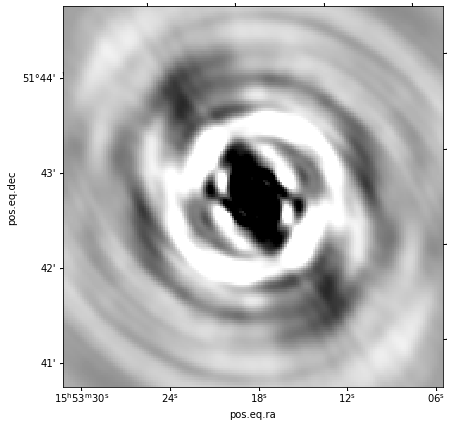

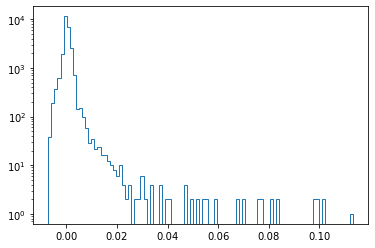

238.47781129228005 52.80270177944592


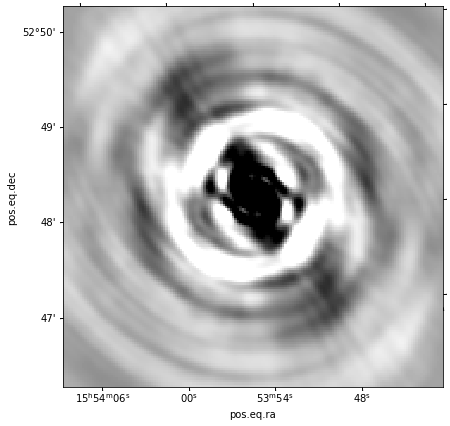

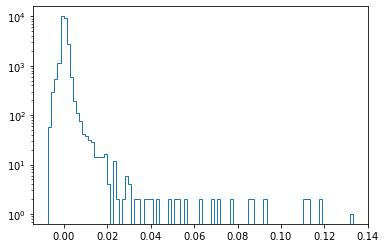

236.88493132603685 52.77204853740643


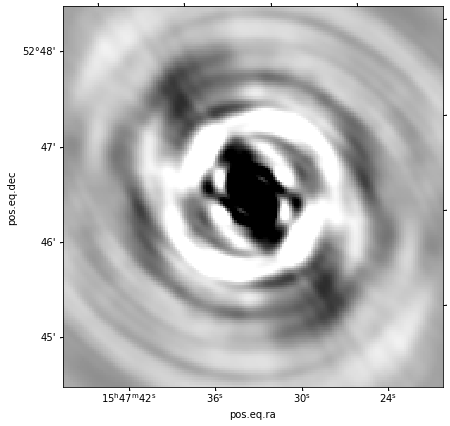

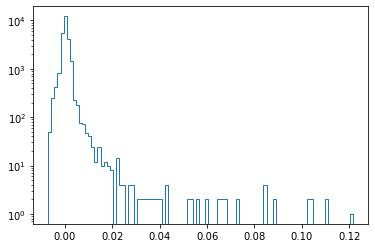

240.0944117112417 54.70629675798857


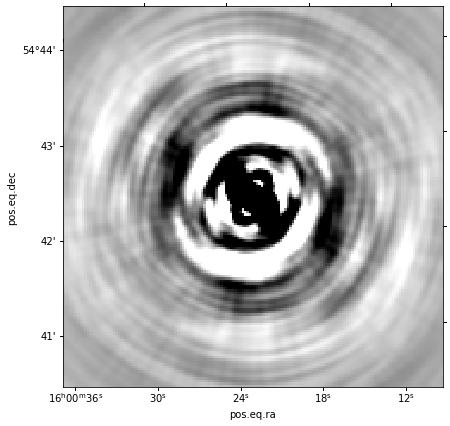

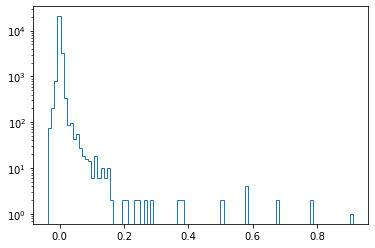

246.99574564937197 56.6615152338725


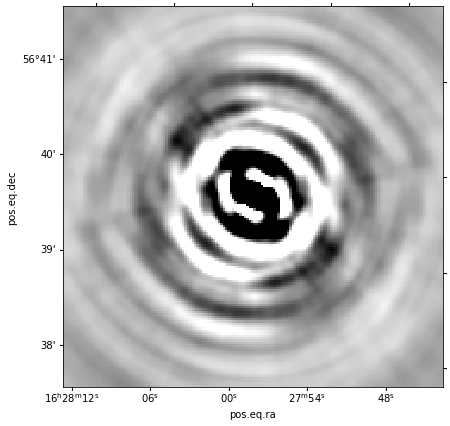

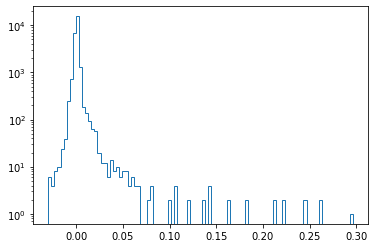

247.7904381112184 53.68448382615225


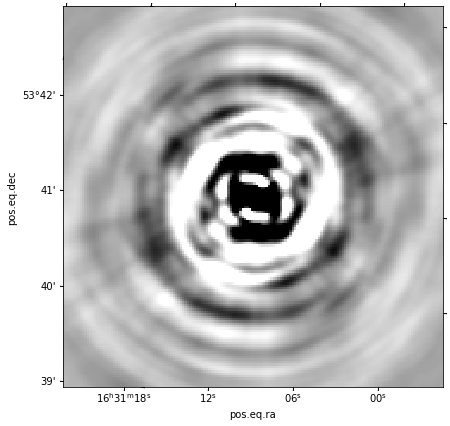

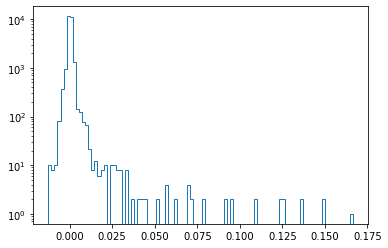

241.47724534978988 53.77512574934195


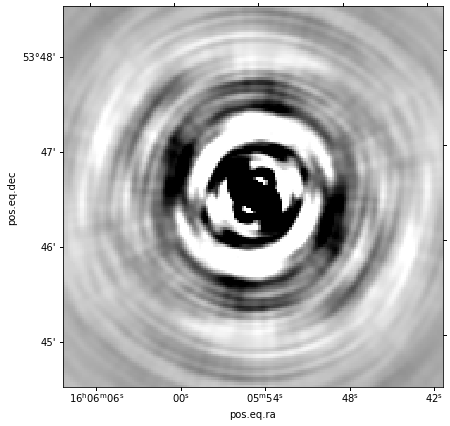

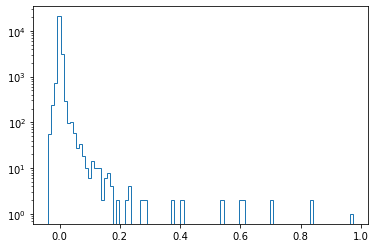

239.70600362192246 55.90836221217303


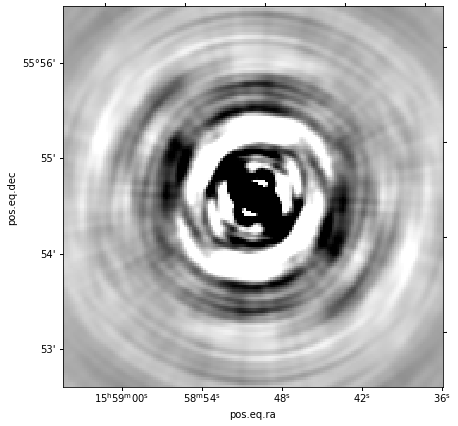

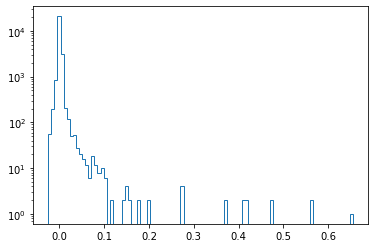

247.46190411149038 54.60270598862891


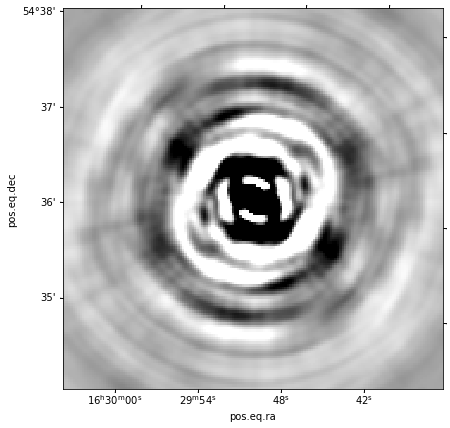

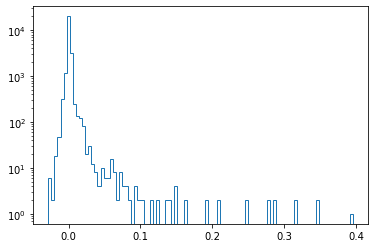

243.4015814005163 52.63459596235454


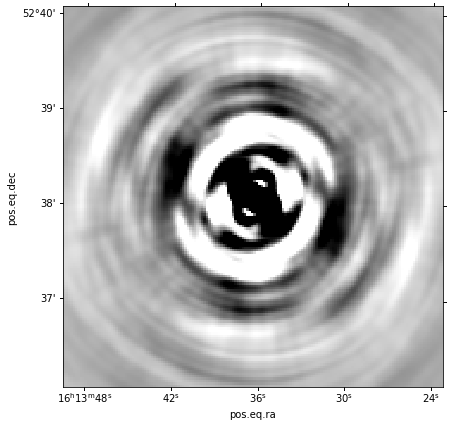

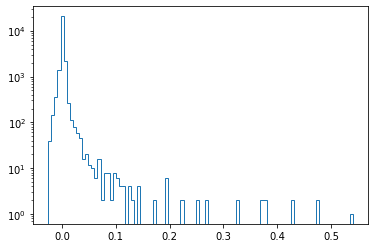

244.86239459498182 56.966729851338684


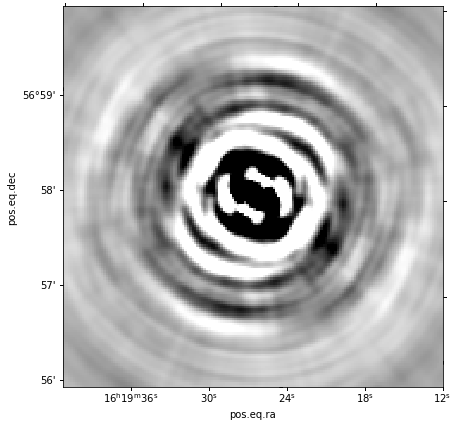

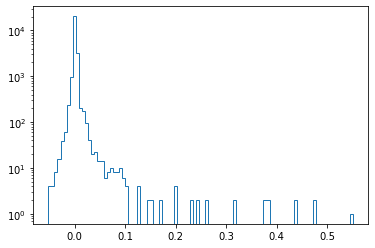

249.0317511743693 53.65497649970301


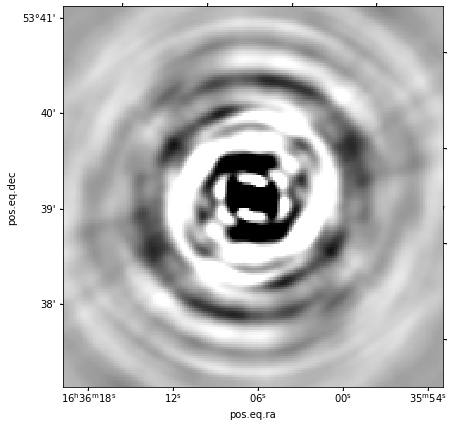

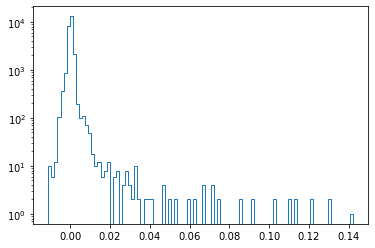

239.03443979024965 56.92610714366391


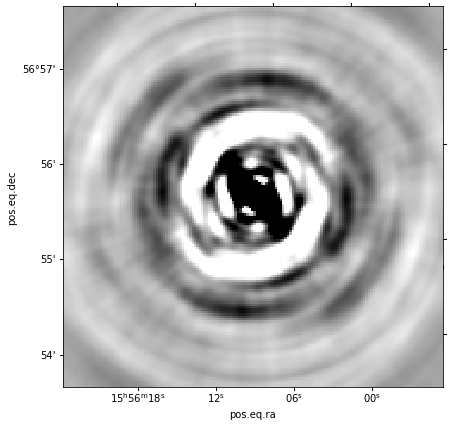

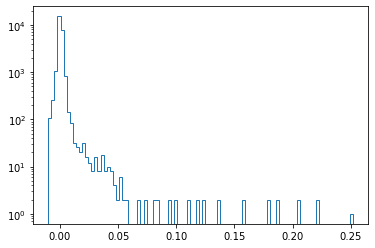

237.54440574823244 56.47284023193592


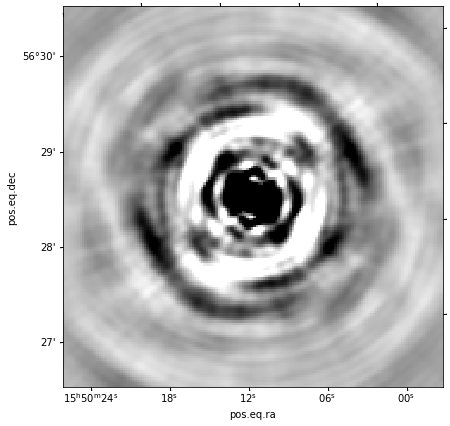

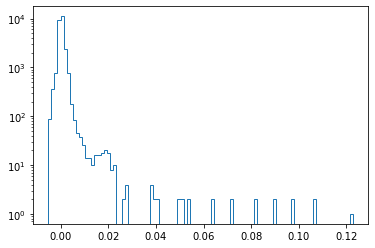

248.0698696279037 55.19588919392786


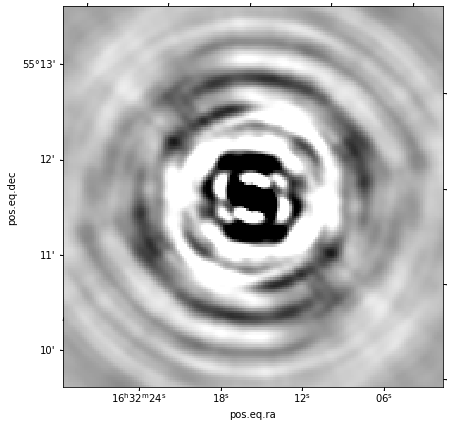

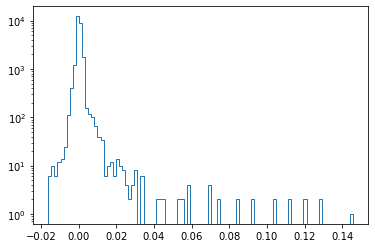

246.49807450852134 54.648141541782785


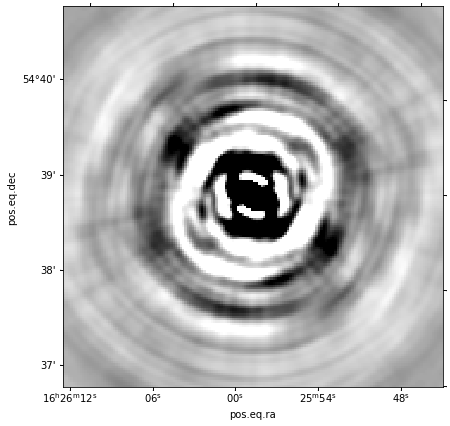

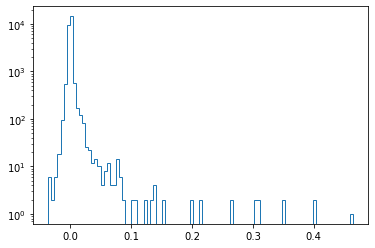

244.20211803187308 53.821420739188525


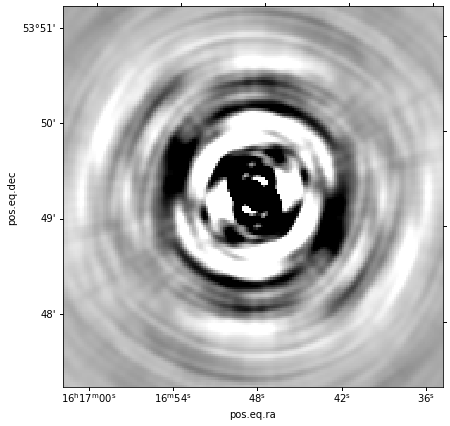

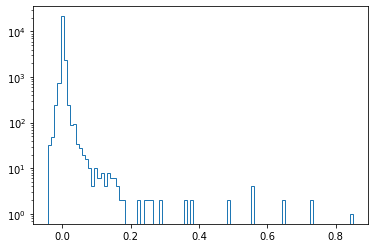

237.00737240685632 51.43797360722381


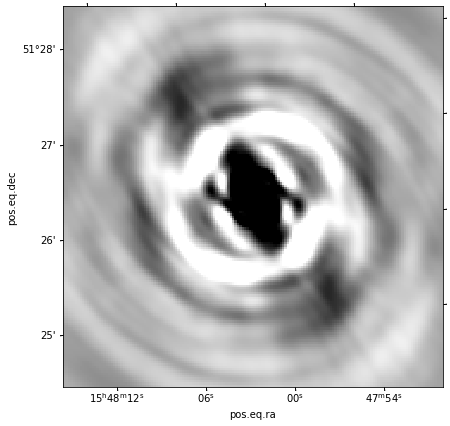

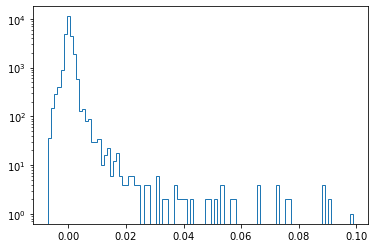

238.65050077173248 58.71396464759014


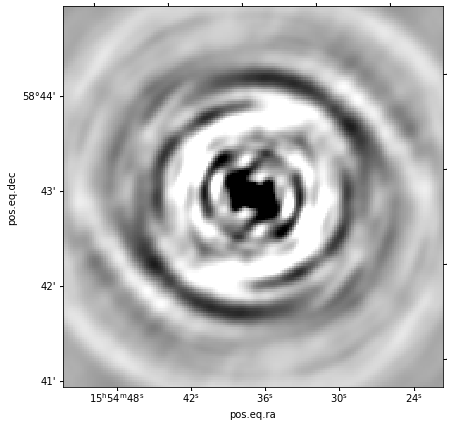

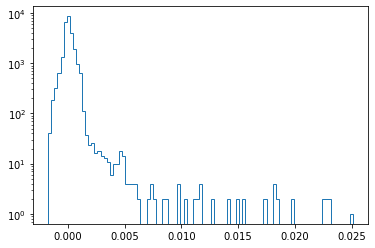

243.13527061733947 54.493958599113085


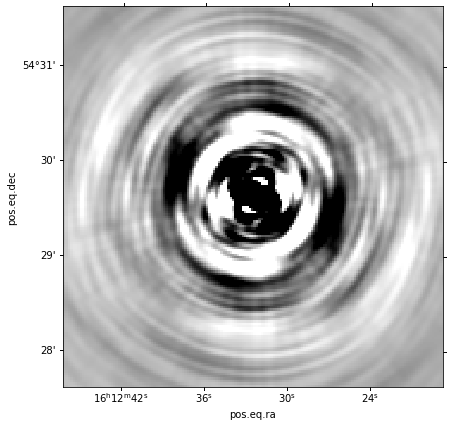

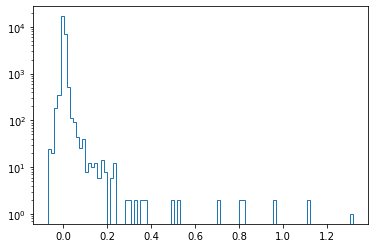

241.1519199137146 57.349580250045115


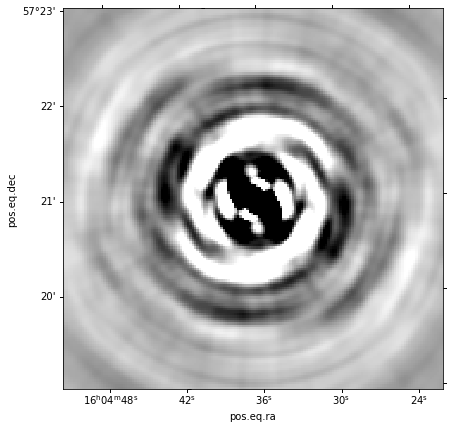

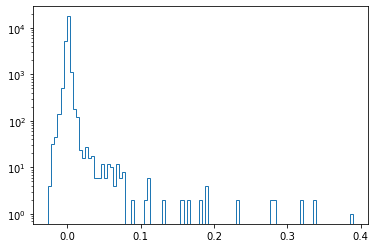

246.20981944179098 55.74564219835588


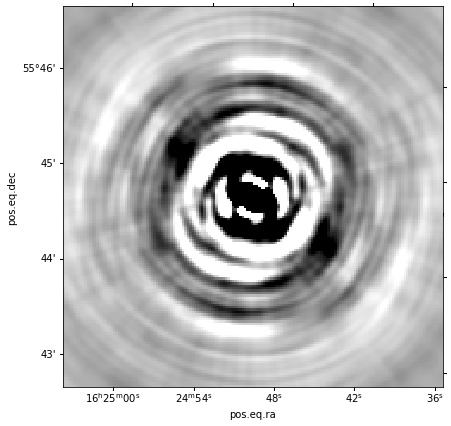

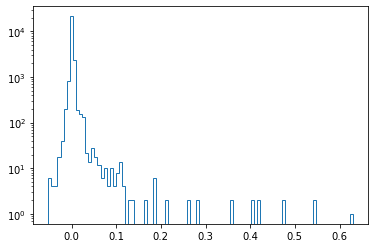

243.46414839174457 51.32561658359866


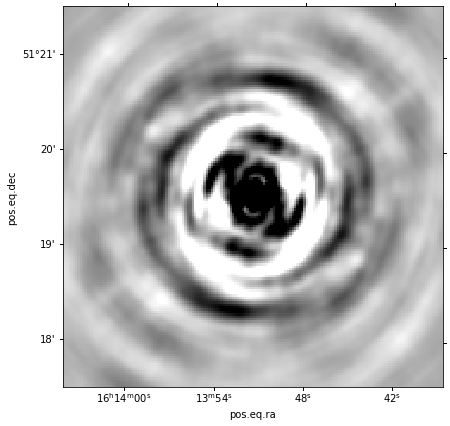

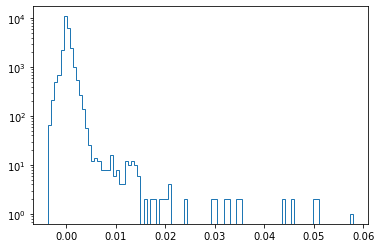

249.2831077590932 54.95037677871429


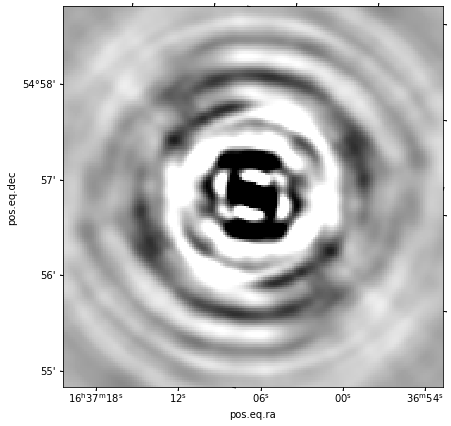

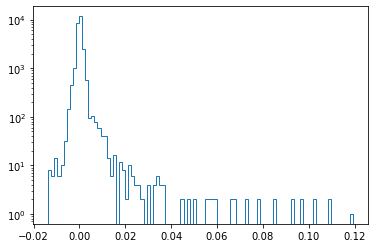

241.8769407076732 55.6248626951423


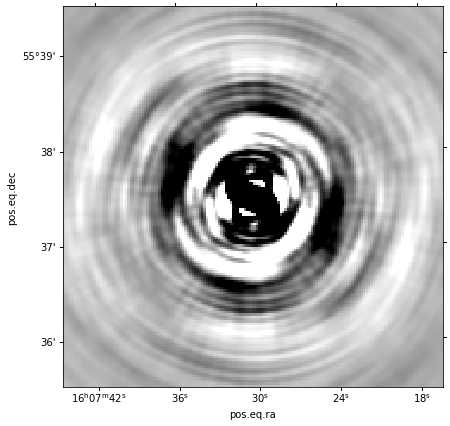

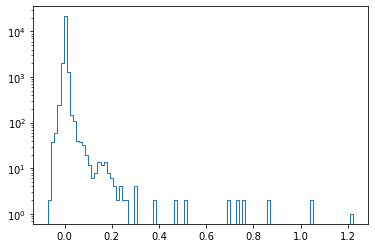

235.92001310325705 57.26506897526332


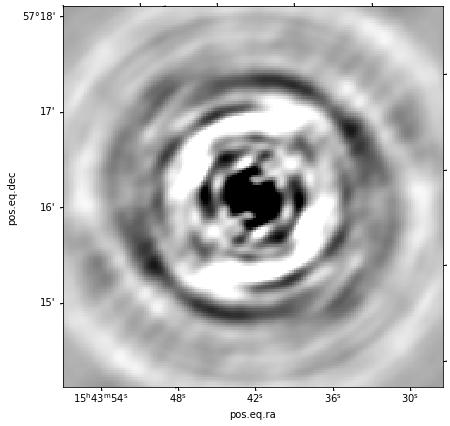

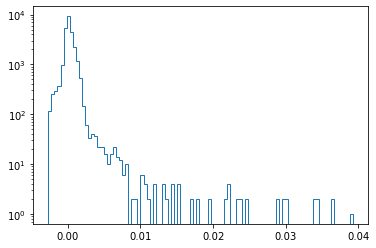

245.2550998677645 54.280016158411236


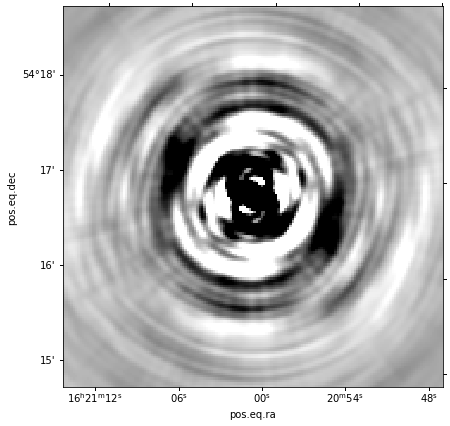

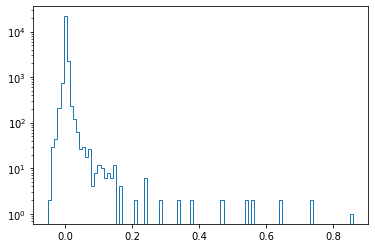

237.04518762133495 58.33776055930724


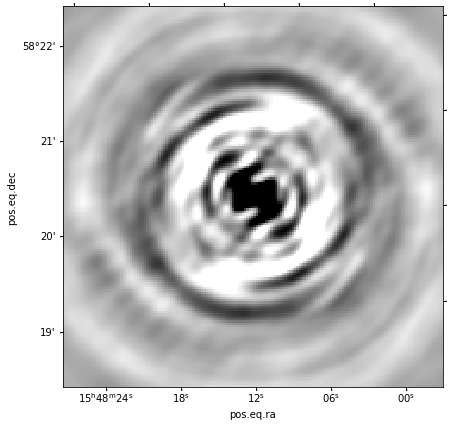

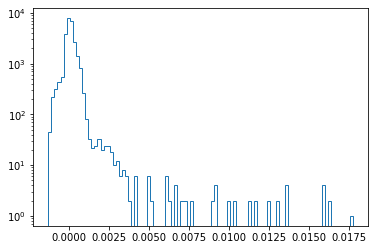

244.6480510838234 55.11235194739778


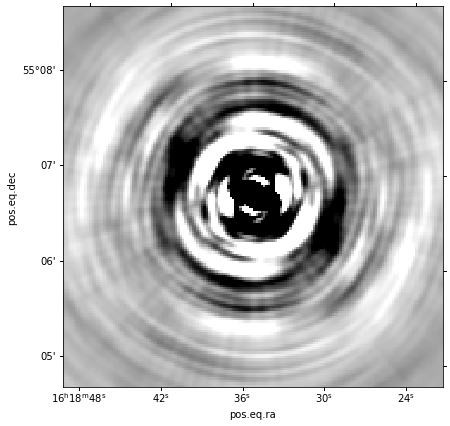

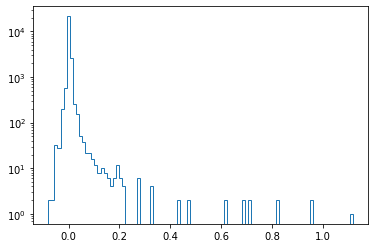

242.03324359418485 51.15103634342229


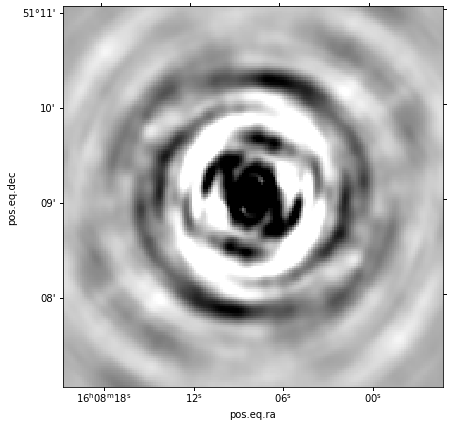

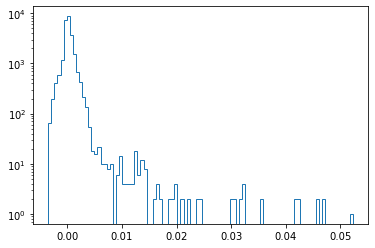

237.57030344057236 54.69300413714153


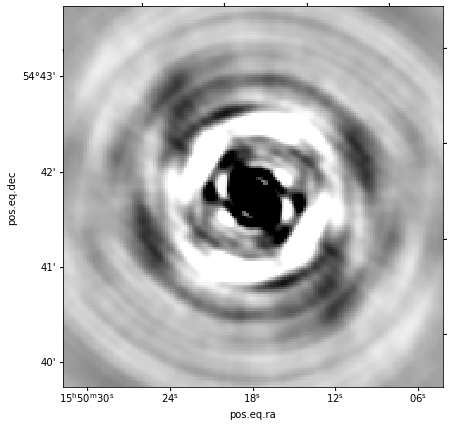

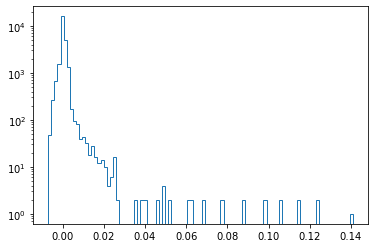

247.3078357603797 51.442270790687296


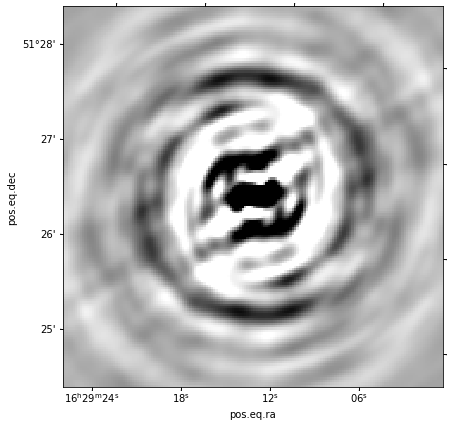

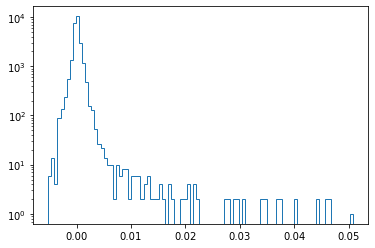

241.0989786134445 56.42562850961715


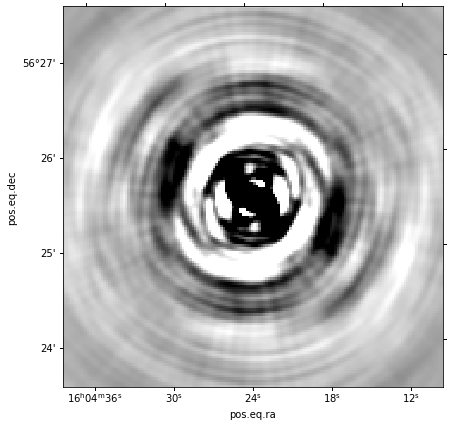

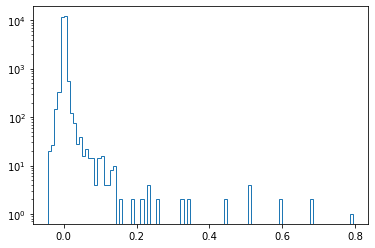

246.2076422021695 52.930987029775714


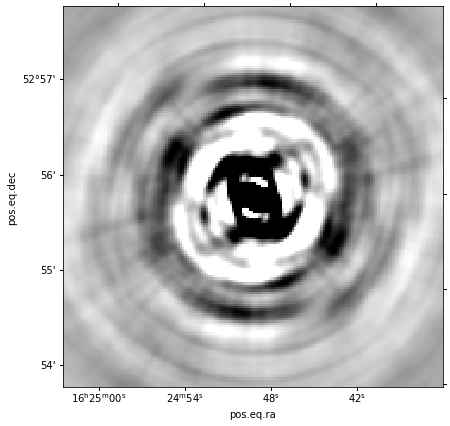

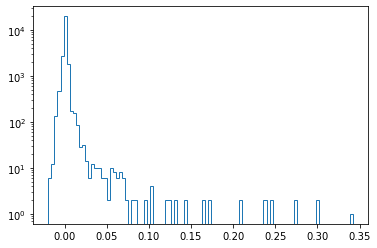

244.6875851716874 53.10814558003016


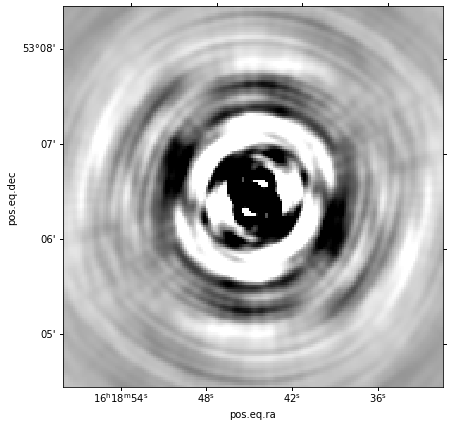

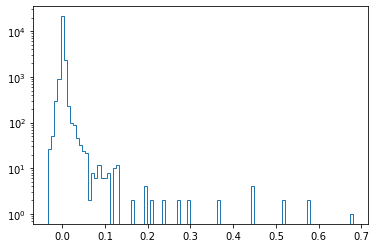

246.25296316376438 51.23193798409477


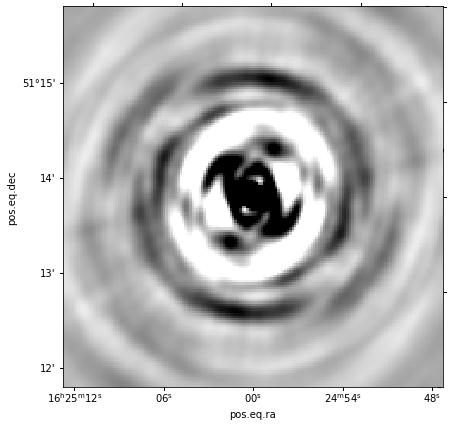

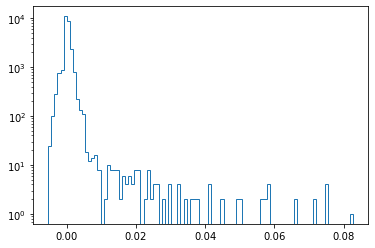

243.03918559509606 53.2756211435469


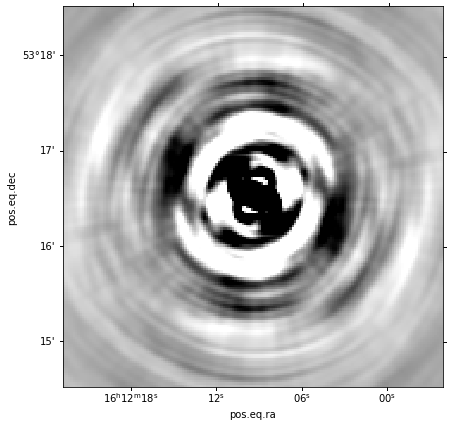

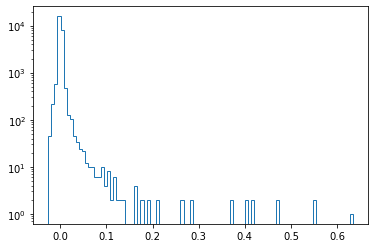

249.38440669727237 57.513274292113984


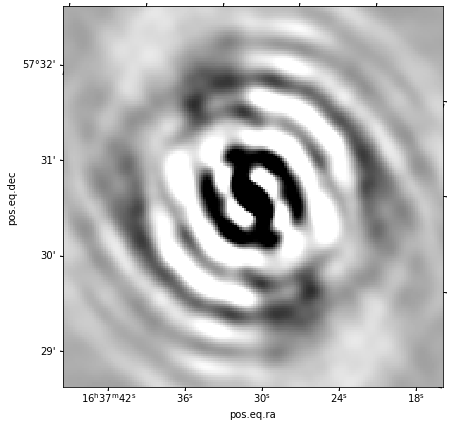

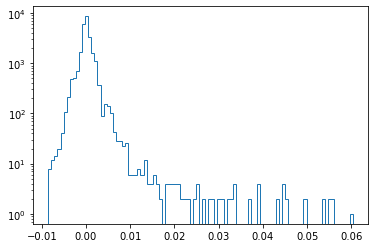

239.35243136654725 52.14529000531281


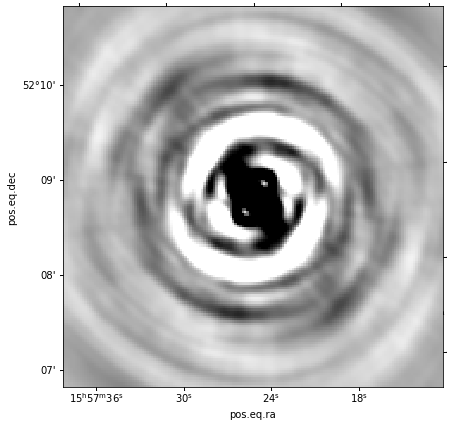

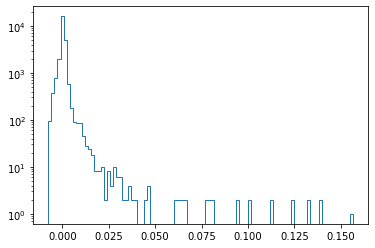

239.0429768613971 51.248782943271614


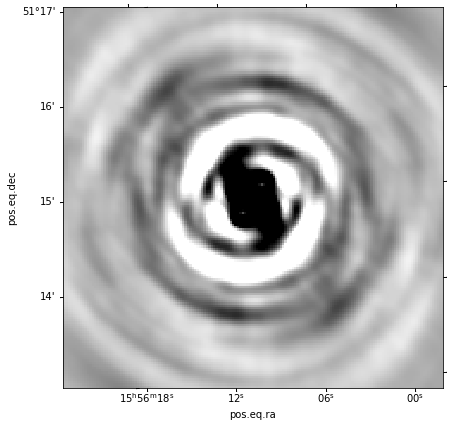

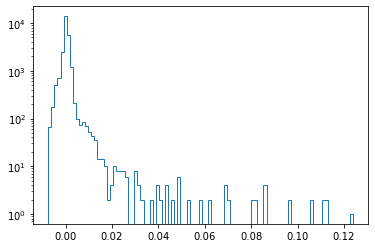

240.31551612438264 52.21255525046118


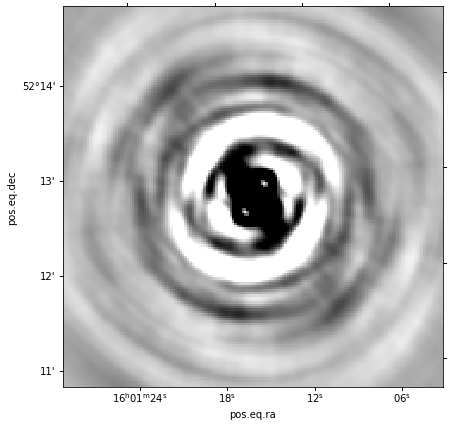

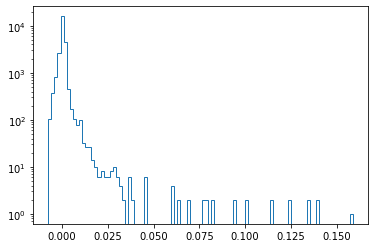

244.78292534879722 52.15193631573633


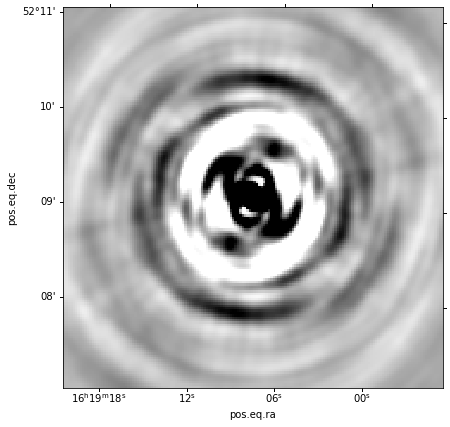

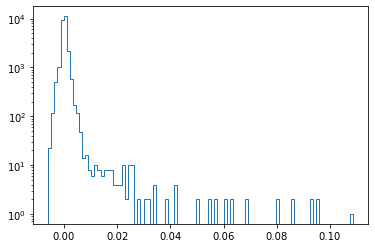

247.21180803391576 52.45457262312443


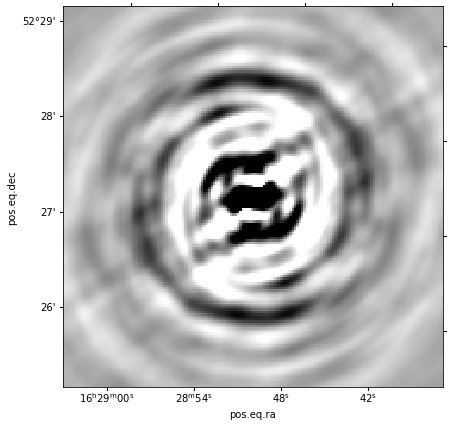

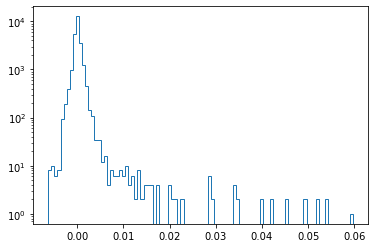

235.62683059948858 58.38331070402013


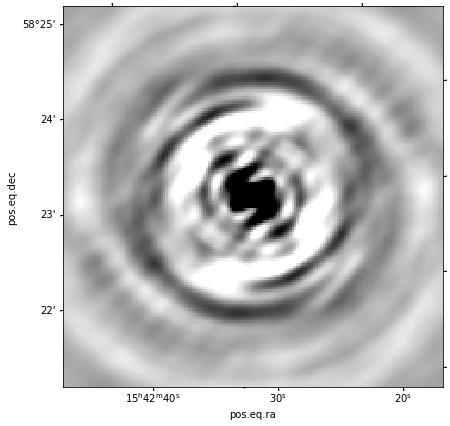

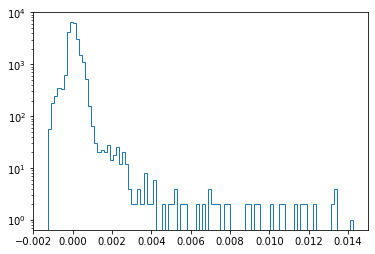

241.47220332119275 52.776116537751854


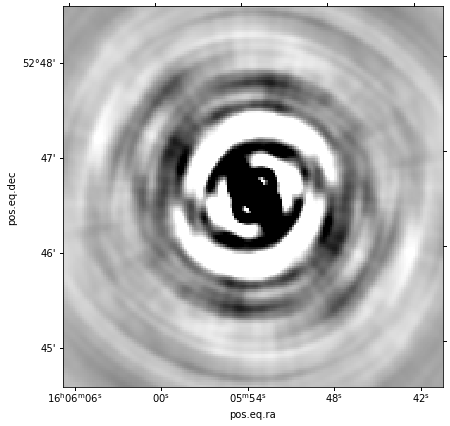

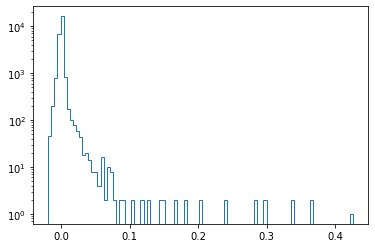

243.2885941233165 56.41691955113115


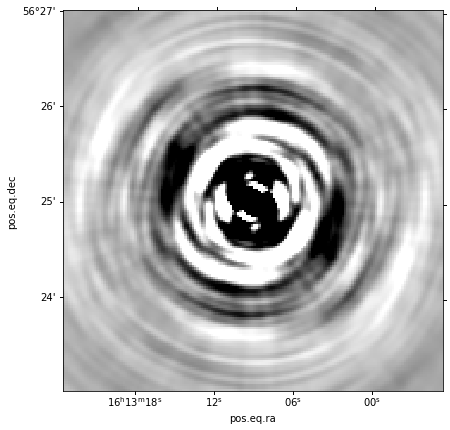

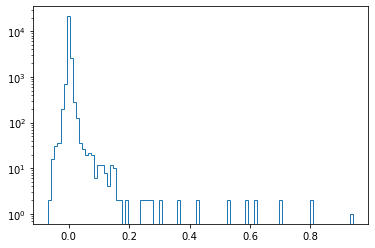

236.26699634398827 55.53141327875646


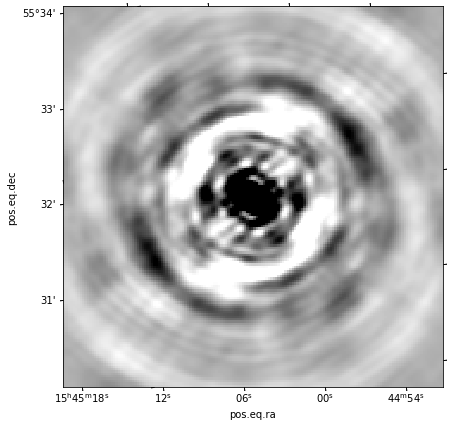

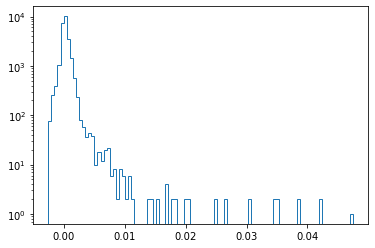

236.4113817083612 53.75988507199148


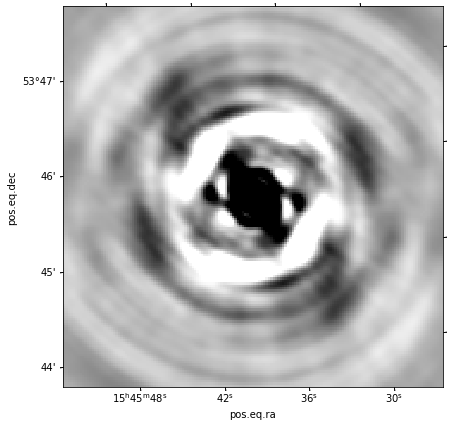

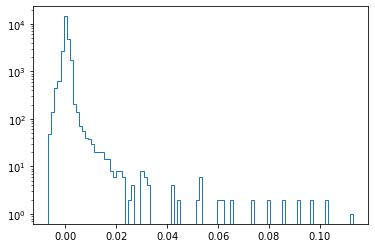

235.95914612066446 56.28611328650278


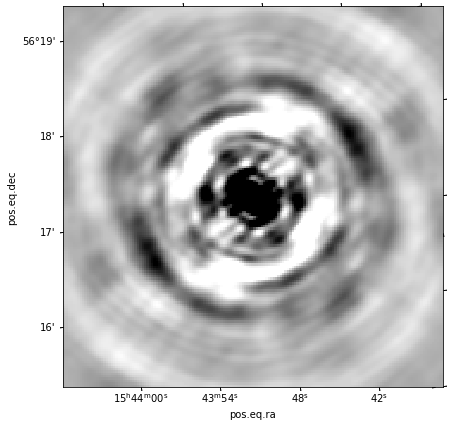

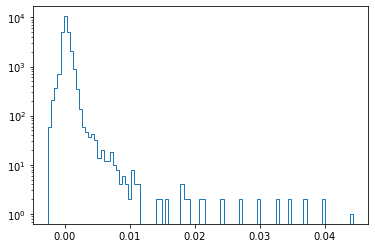

242.56265659688572 56.9873563319634


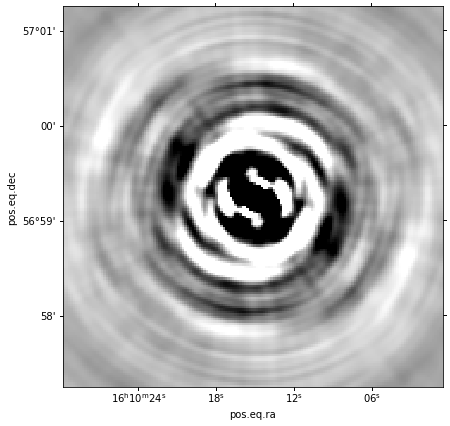

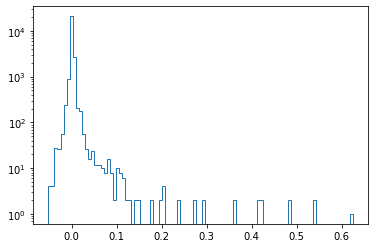

241.62890727816105 54.84856217851956


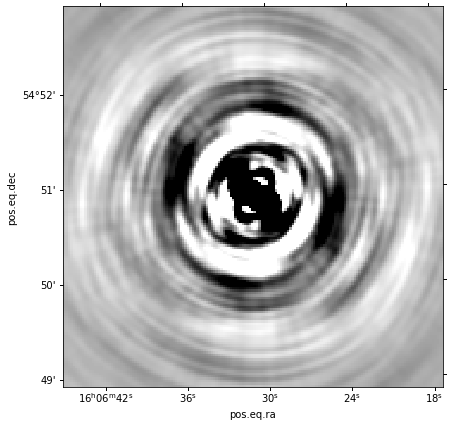

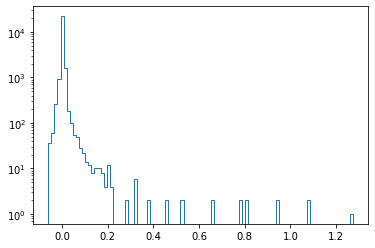

244.83191324028087 51.335242274556855


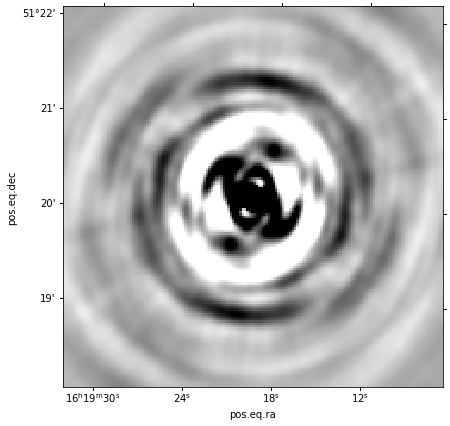

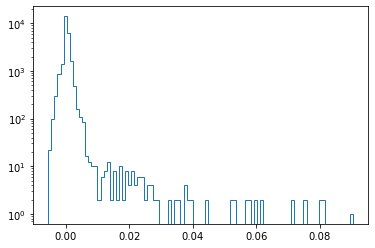

236.35288271747837 54.67478407925637


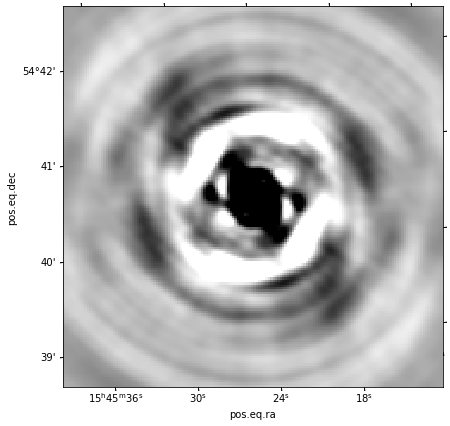

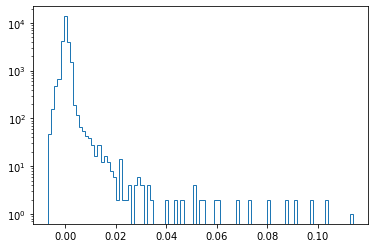

245.51780101683198 57.773110652205816


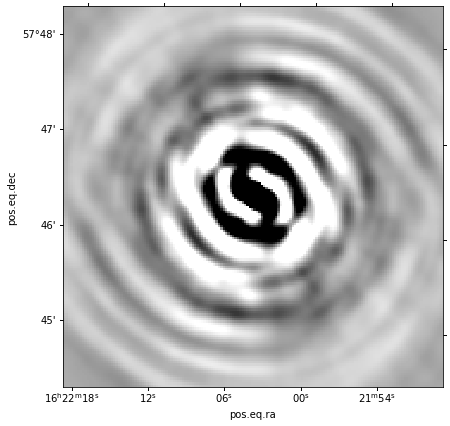

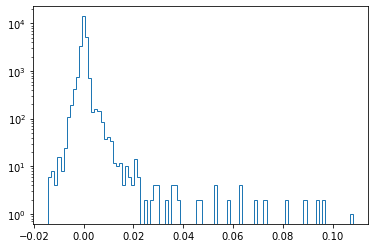

243.95133440494433 57.735925691301816


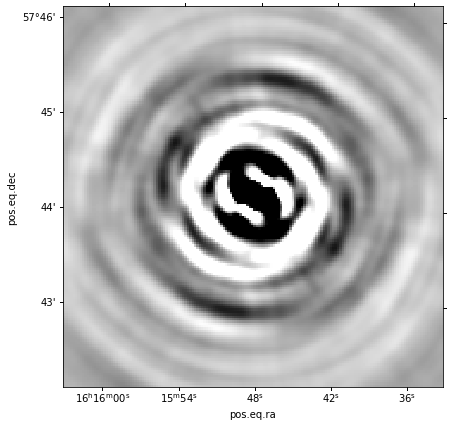

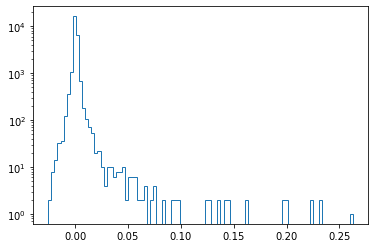

246.323723451463 53.56187085799426


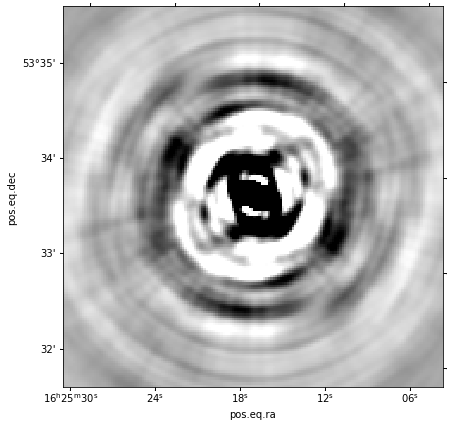

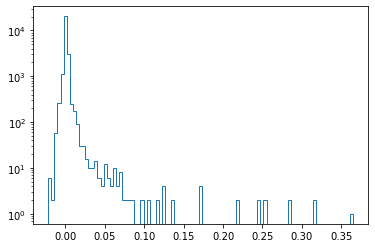

248.70894675259262 52.42655498694254


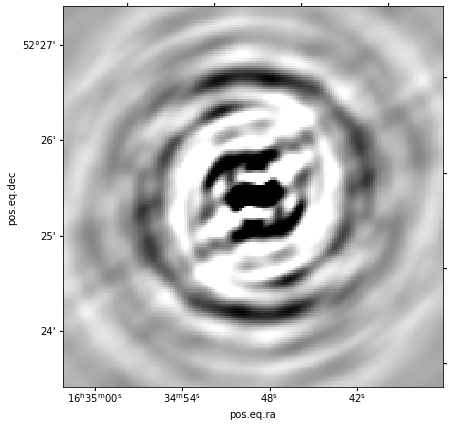

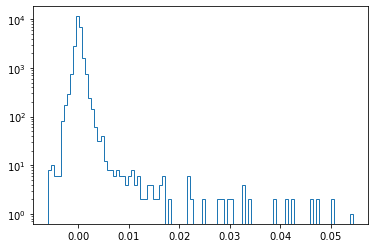

247.71234396374206 57.51172730606713


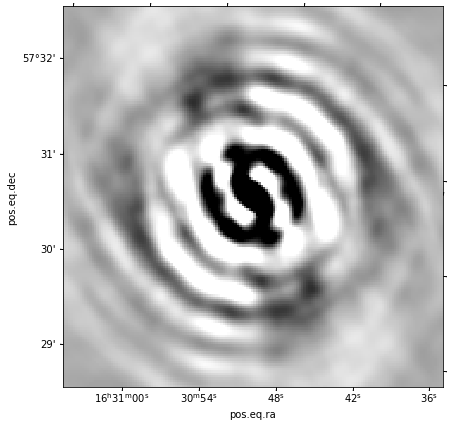

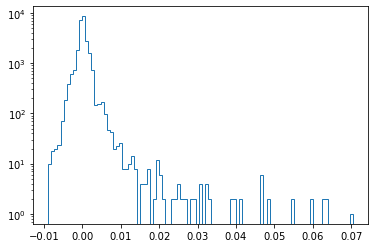

248.56668133206165 51.291697482126914


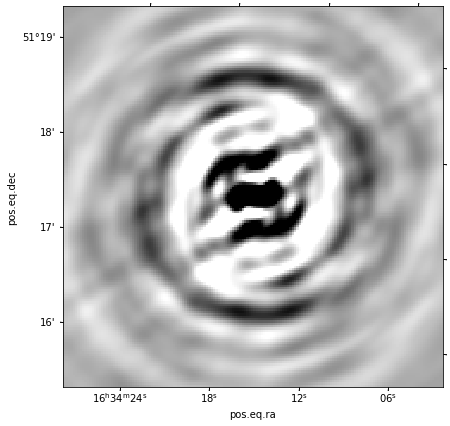

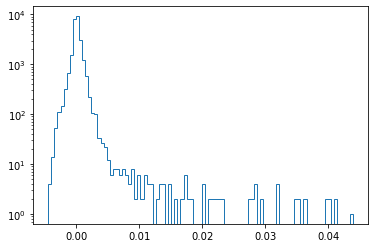

240.47187630667386 52.87586848988413


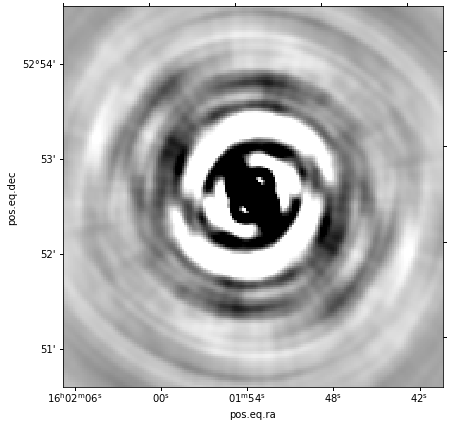

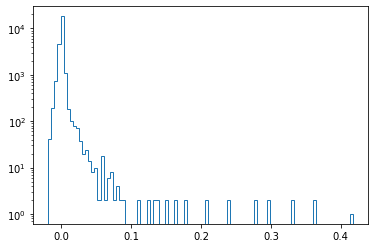

249.70285663980604 56.85620629265795


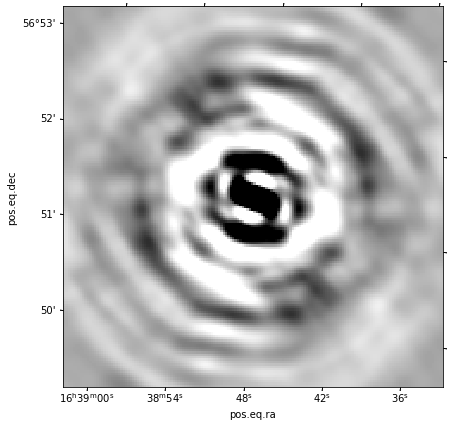

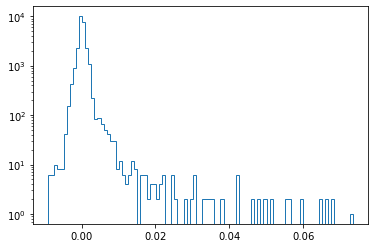

237.3683358177887 57.38710898562618


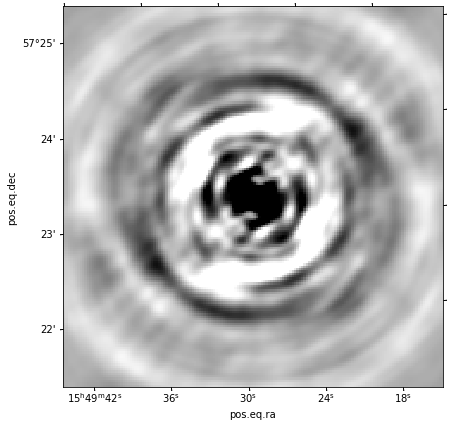

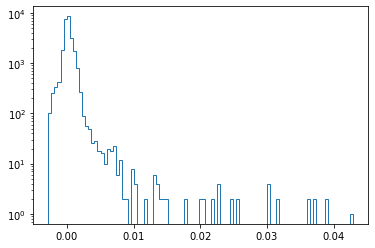

248.0348619066212 58.472405641162986


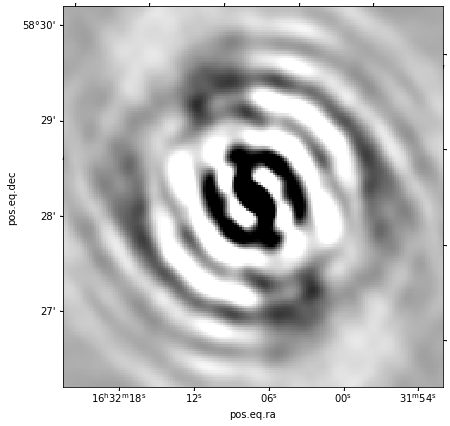

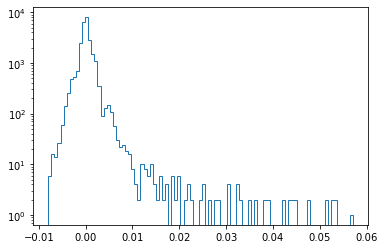

240.4505049809155 51.36188481203043


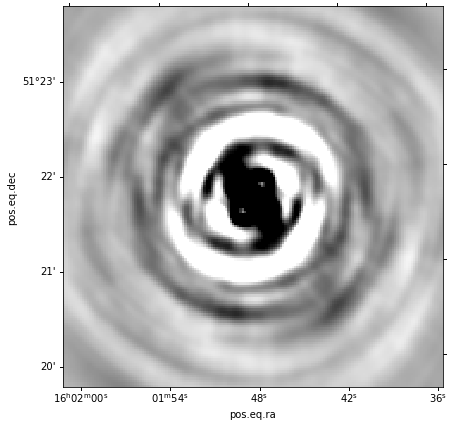

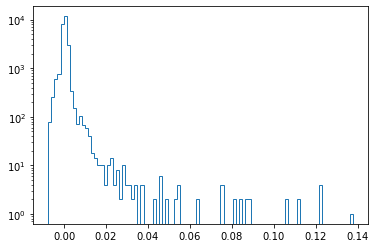

242.72887165325315 57.78233527270742


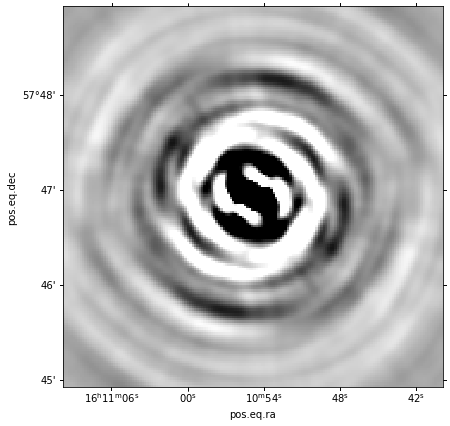

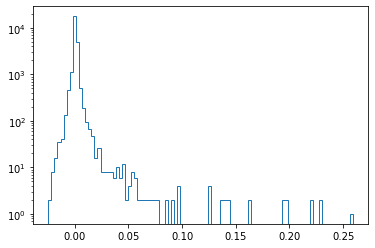

246.48163061980108 57.7091112664897


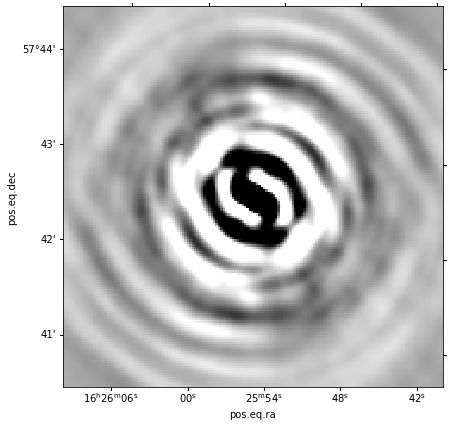

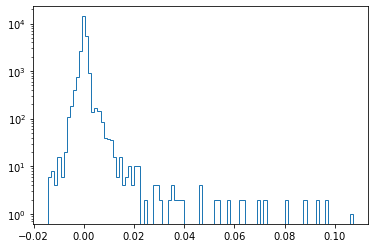

249.68412091990527 58.43189752504724


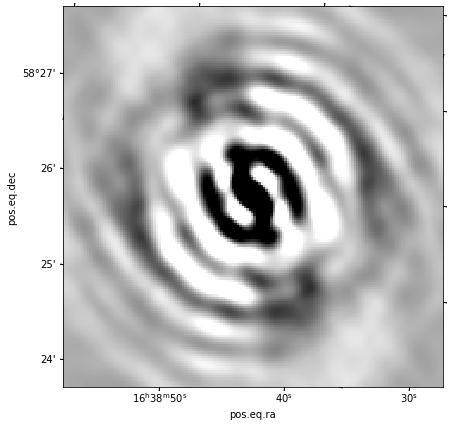

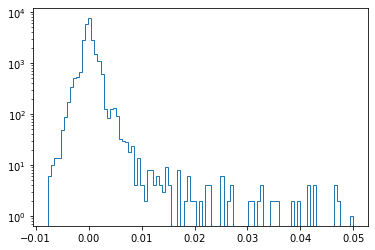

242.72680900519072 58.61696289287449


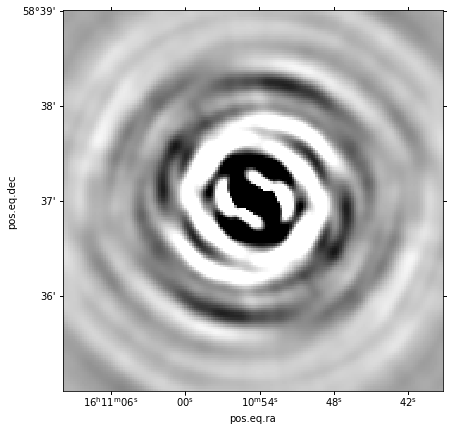

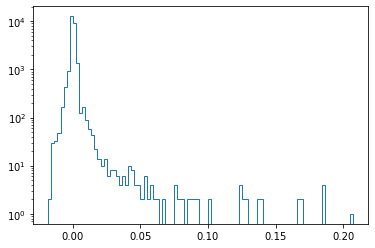

246.00762263588936 52.09171845146808


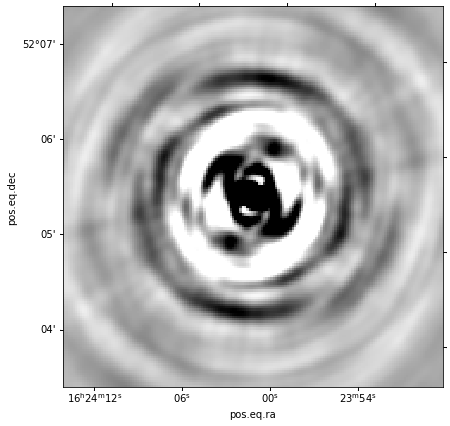

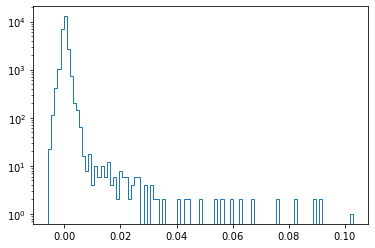

246.81182619713496 58.62561455558096


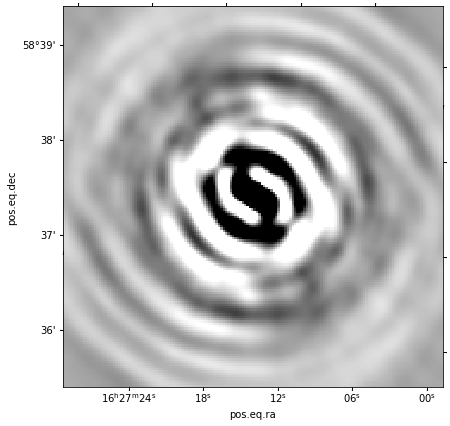

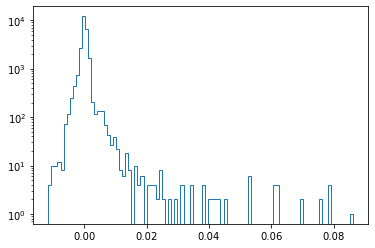

238.6607567162653 57.9675152320937


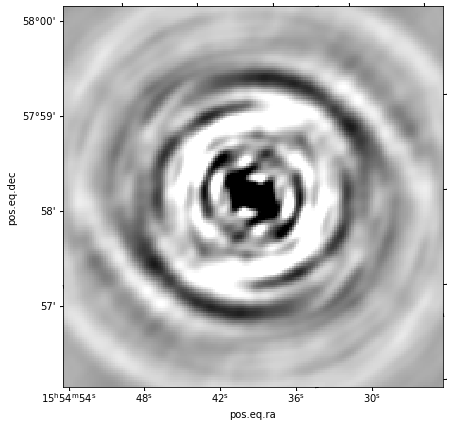

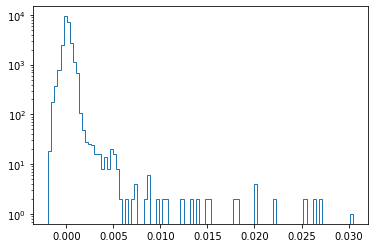

238.92517673871816 55.503739417251644


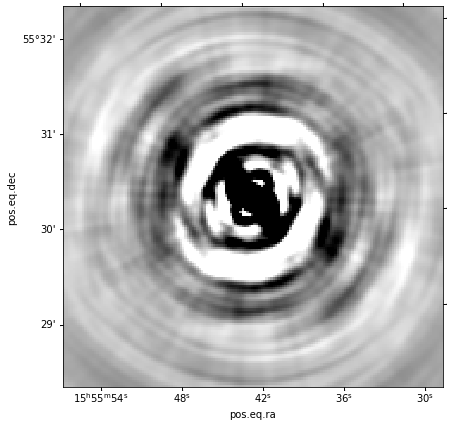

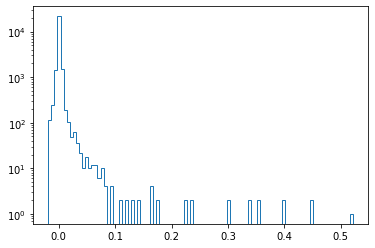

238.97886288412198 54.98876495098806


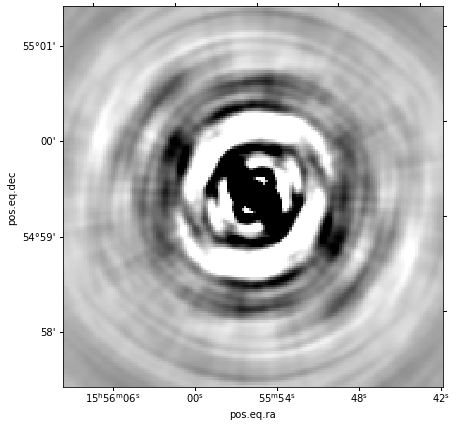

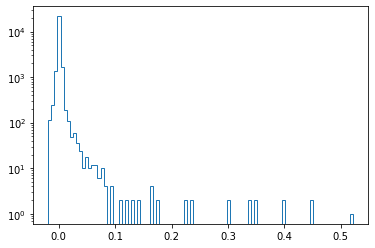

238.67565361893872 53.44538853824417


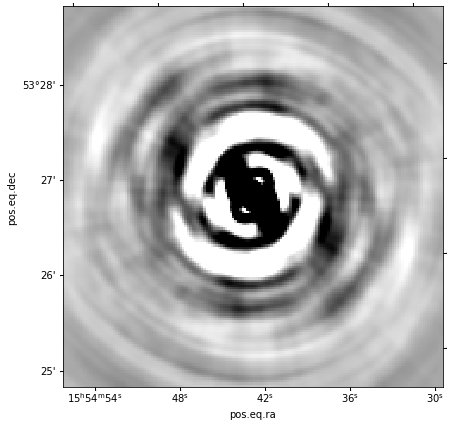

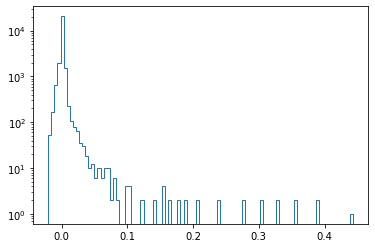

239.7052014810093 53.339792416601554


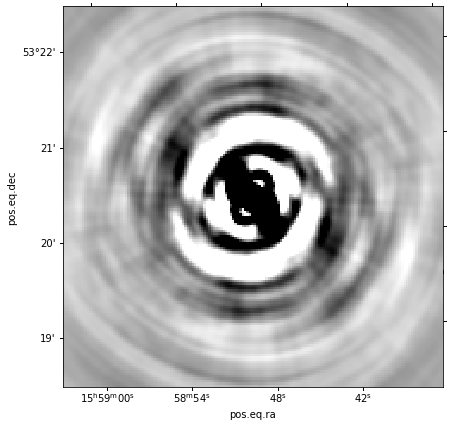

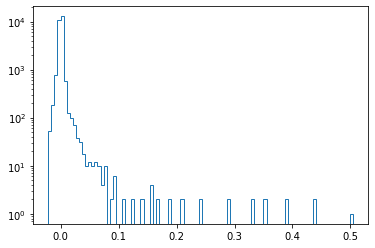

238.15758518058146 54.962237005073504


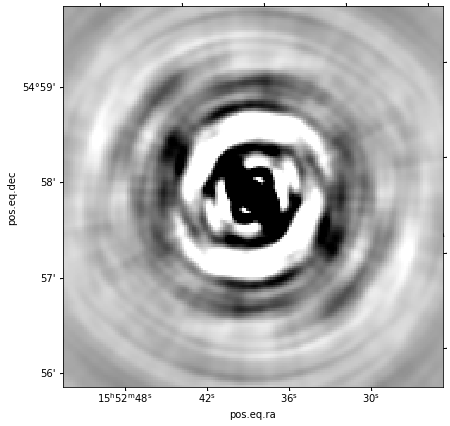

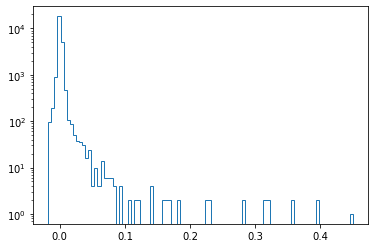

244.04598703269994 58.62991173904445


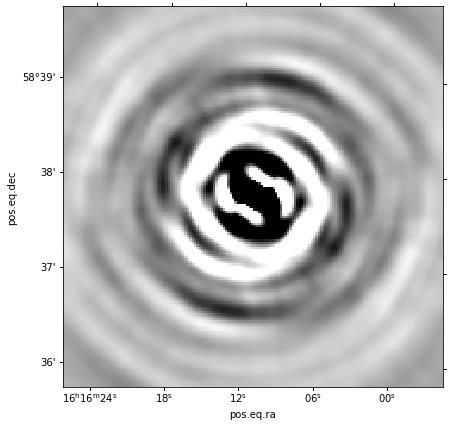

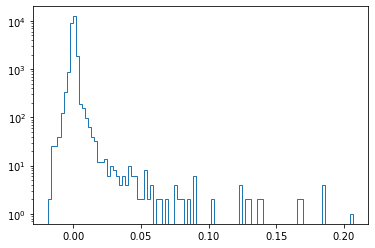

238.54696729815234 53.99199027479897


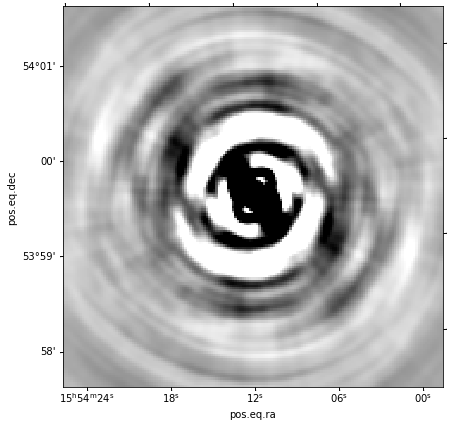

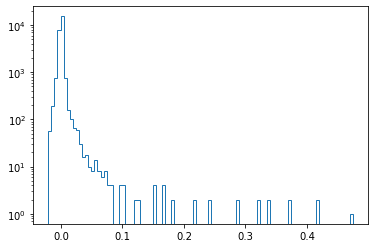

248.2125934146708 56.05813337982023


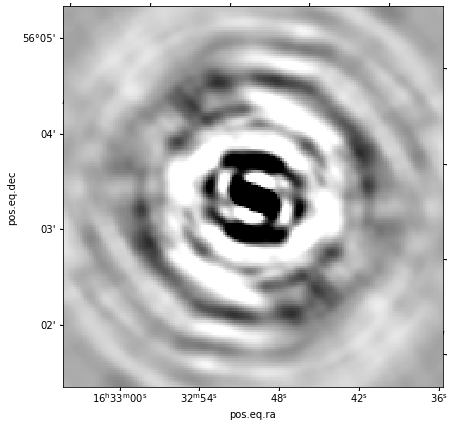

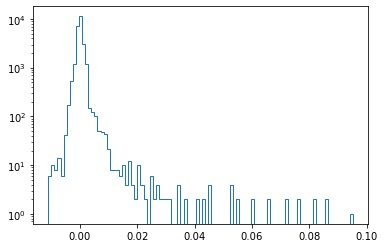

240.01723429623755 57.80645679588242


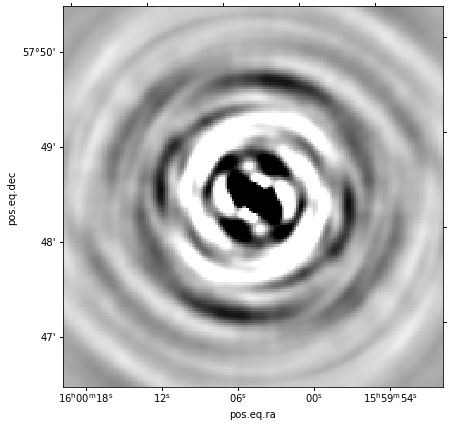

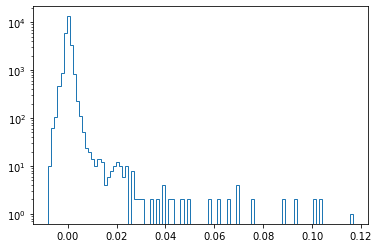

240.21673820050214 58.618108808464754


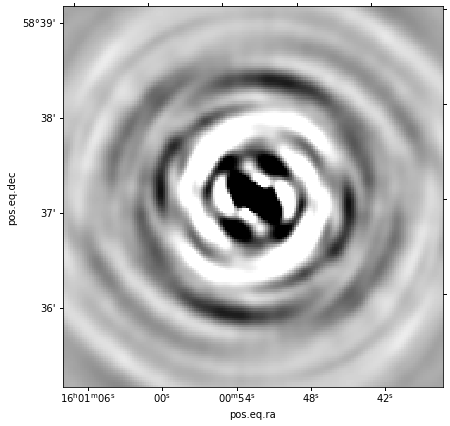

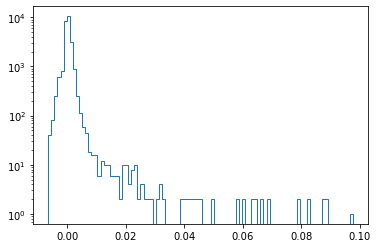

245.4639429840897 58.63380785205133


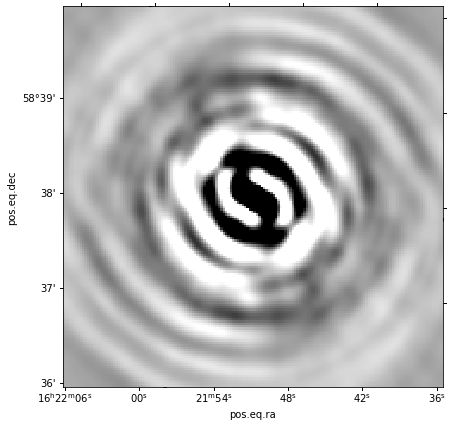

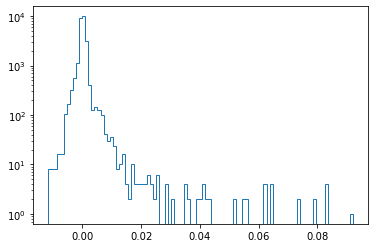

242.96269572944607 52.18493868473587


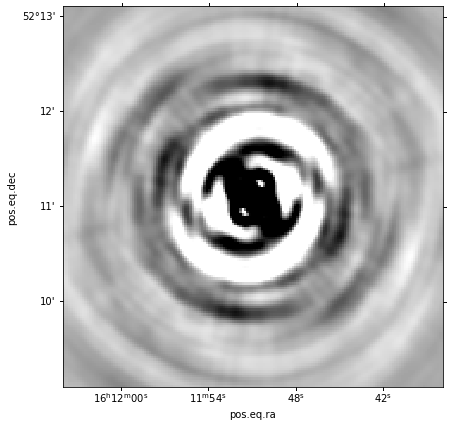

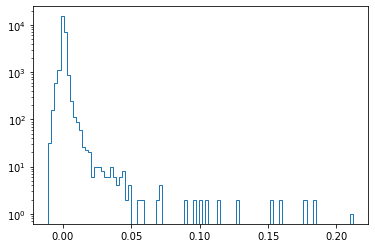

244.57058718992172 55.967204977732976


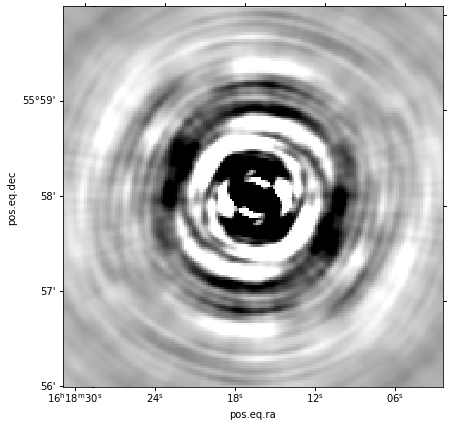

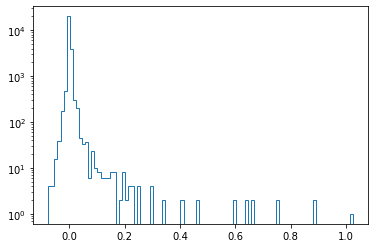

241.78784577053028 51.64102984981818


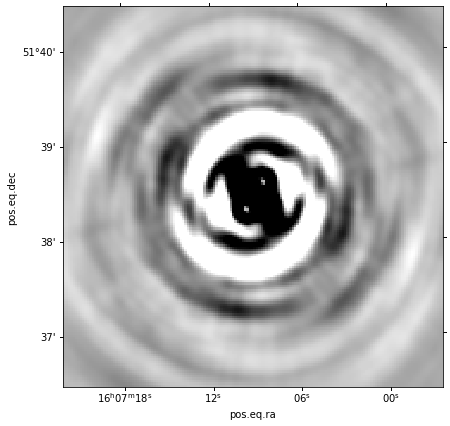

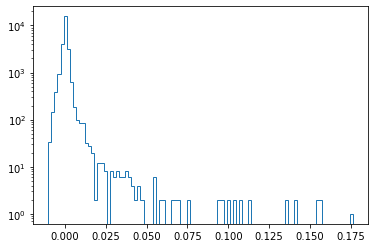

241.99949638005168 52.239369675273295


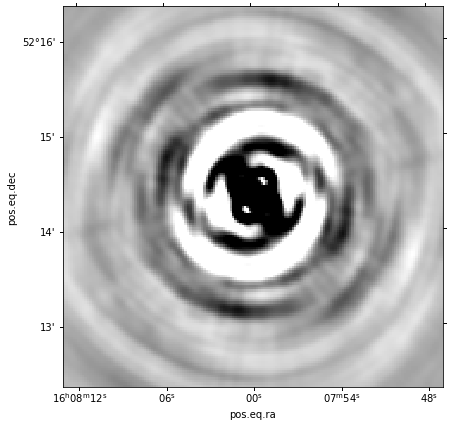

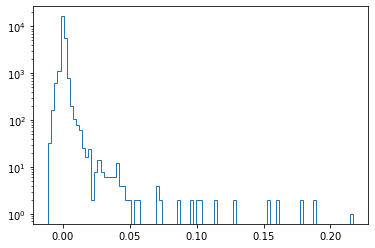

243.27553068558748 55.57432781761177


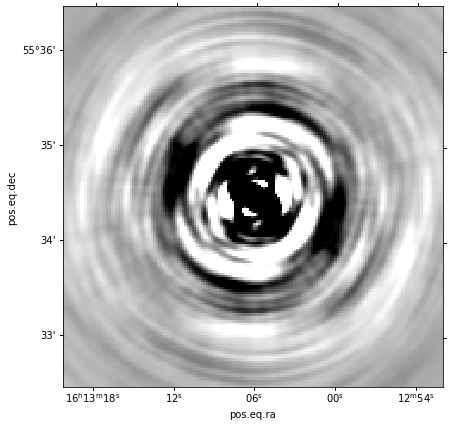

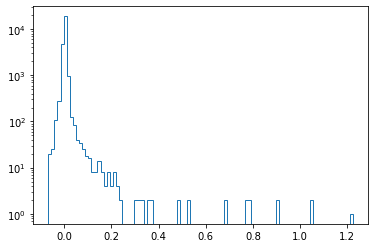

249.48370028316853 56.0312616592286


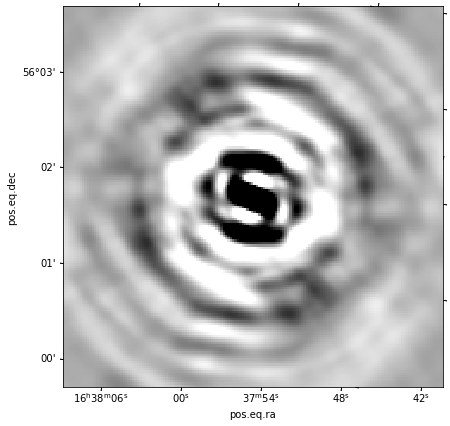

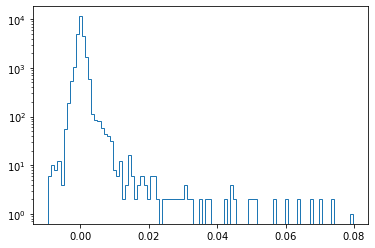

237.59843566831321 53.979728977983164


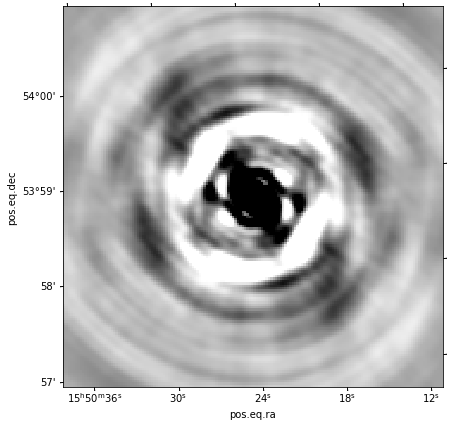

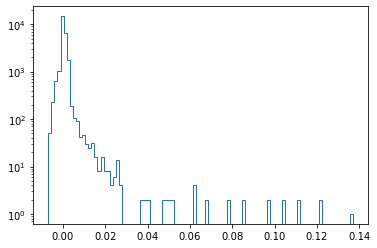

241.41456376700262 58.69883856179869


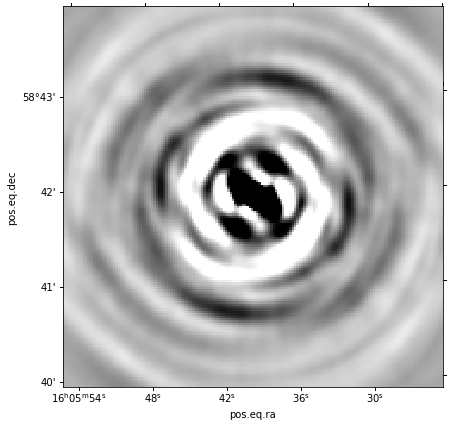

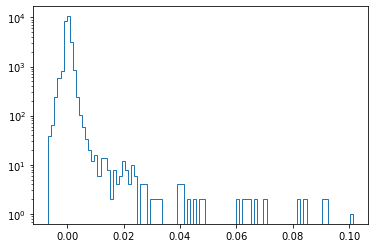

239.60739758538045 53.96219646945217


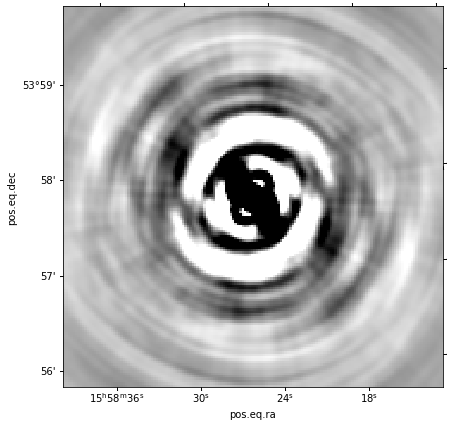

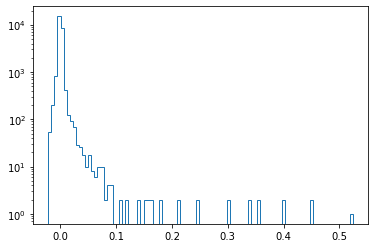

237.88044549507669 55.56298325326818


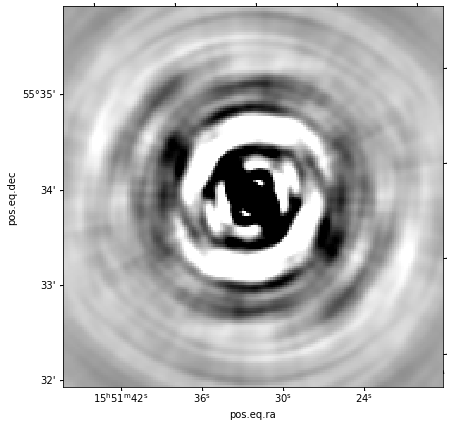

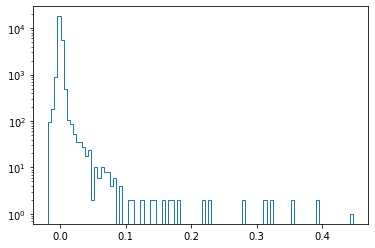

242.8059344766983 51.82792868258985


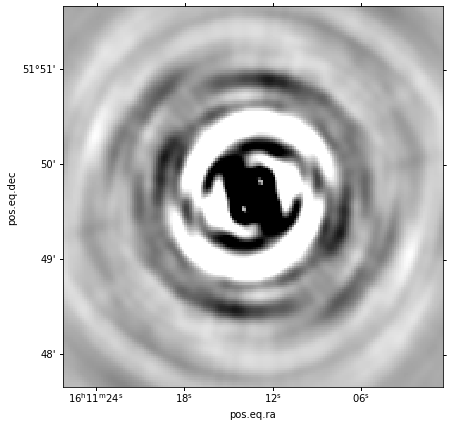

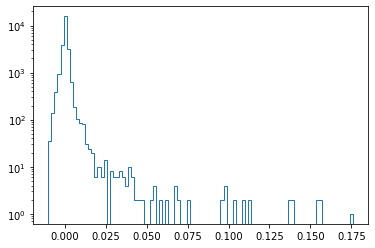

241.24548392165948 58.00487208033623


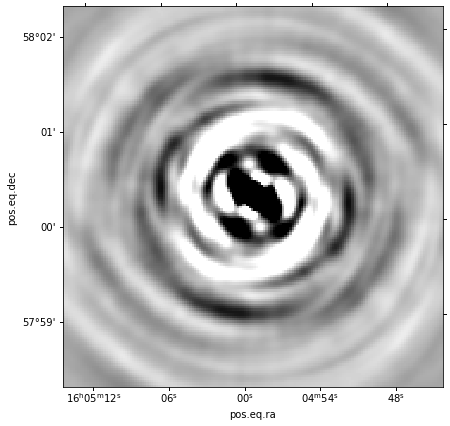

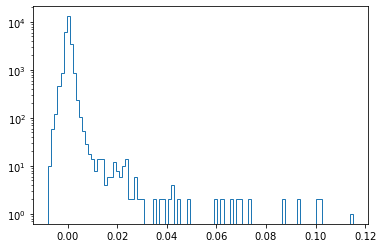

248.61738809693068 56.7324474089097


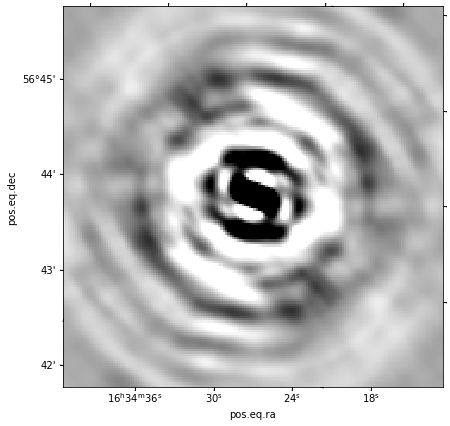

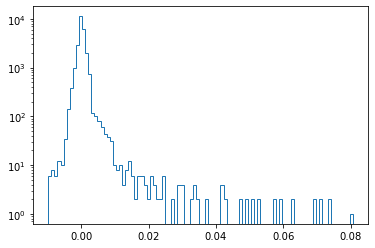

In [14]:
fig = plt.figure(figsize=[7,7])
ra = psf_coords[:,0]
dec = psf_coords[:,1]
box_length = 1/15
for n in range(len(ra)):
    #image_plotting.plot_figure(radim_data,psf_coords,radim_wcs,ra[n],dec[n],plot_params)
    fig = plt.figure(figsize=[7,7])
    print(ra[n],dec[n])
    image_plotting.image_plot(radim_data_psf,ra[n],dec[n],radim_wcs_psf,box_length,fig)
    plt.show()
    
    imgcut,wcscut = get_cutout_data_and_wcs(radim_data_psf,ra[n],dec[n],radim_wcs_psf,box_length)
        
    bins=np.arange(-1.1,-0.5,0.01)
    bins=np.linspace(np.min(imgcut)-np.min(imgcut)/100,np.max(imgcut)+np.max(imgcut)/100,100)
    plt.hist(imgcut.flatten(),bins=bins,histtype='step',log=True)
    #plt.vlines(0.1,ymin=0,ymax=100,color='black')
    plt.show()

In [21]:
#As the PSF extends across the entire facet we don't want to use the full PSF.
#I take a postage stamp around the centre of each PSF with a width of 2 arcminutes (81 pixels)
#and use that as the PSF

ra = psf_coords[:,0]
dec = psf_coords[:,1]

lengths = [15,30,60,120,240]

psfs = []
for m in range(len(ra)):
    nums = []

    box_length = 1/30

    imgcut,wcscut = get_cutout_data_and_wcs(radim_data_psf,ra[m],dec[m],radim_wcs_psf,box_length)

    if (imgcut.shape[0]%2==0) or (imgcut.shape[1]%2==0):
        box_length_x = box_length + (1-imgcut.shape[0]%2)*(radim_pixsize/3600)
        box_length_y = box_length + (1-imgcut.shape[1]%2)*(radim_pixsize/3600)
        box_length = [box_length_y,box_length_x]
        imgcut,wcscut = get_cutout_data_and_wcs(radim_data_psf,ra[m],dec[m],radim_wcs_psf,box_length)

    
    '''psf_lim = 0.01

    mask = imgcut<psf_lim
    psf = imgcut
    psf[mask] = 0'''

    psfs.append(psf)
        

psfs = np.array(psfs)
#[print(psf.shape[0],psf.shape[1]) for psf in psfs if (psf.shape[0]%2==0) or (psf.shape[1]%2==0)]

Dump the cut down PSF and coords into a pickle file

In [22]:
pixsizes = [radim_pixsize for n in range(len(psfs))]
pickle.dump( [psfs,coords,pixsizes], open( "data/PSF_coords.pkl", "wb" ) )